In [296]:
!pip install prophet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [297]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics

In [298]:
# Imported Fact Order dataset
factOrder_df = pd.read_csv('FactOrder.csv')


# Find number of rows and columns of the dataset
print(factOrder_df.shape)

(1399850, 16)


In [299]:
factOrder_df

OrderNumber  OrderRowNumber  ArticleKey    ArticleName      Colour  \
0           94444500               1       31182  Artikel 31182         NaN   
1           94543600               2       47942  Artikel 47942         red   
2           94543600               3        6763   Artikel 6763  light grey   
3           94543700               1       20870  Artikel 20870    offwhite   
4           94543700               2       38070  Artikel 38070  light grey   
...              ...             ...         ...            ...         ...   
1399845    116135100               3       56158  Artikel 56158        Blue   
1399846    116135100               4       33839  Artikel 33839        Blue   
1399847    116135100               5       54492  Artikel 54492    Offwhite   
1399848    116135100               6       35487  Artikel 35487    Offwhite   
1399849    116135100               7       12249  Artikel 12249        Blue   

             ArticleGenre     Size ArticleGroupName Collection   SizeGroup  \
0                  Övrigt      NaN              VAT       Base         NaN   
1        DRESSES LS WOVEN  116/122          DRESSES       Main  6[116-122]   
2             SWEATSHIRTS    92/98             TOPS       Main    4[92-98]   
3                 TEES LS    80/86             TOPS       Main    3[80-86]   
4             SWEATSHIRTS    80/86             TOPS       Main    3[80-86]   
...                   ...      ...              ...        ...         ...   
1399845           TEES LS  104/110             TOPS       Main  5[104-110]   
1399846   TROUSERS JERSEY    92/98          BOTTOMS       Main    4[92-98]   
1399847          LEGGINGS    92/98          BOTTOMS        Pre    4[92-98]   
1399848           TEES SS  104/110             TOPS        Pre  5[104-110]   
1399849    TROUSERS WOVEN  104/110          BOTTOMS        Pre  5[104-110]   

        BabyJunior ArticleMaterial  DateOrderedKey  QuantityOrdered  Amount  \
0              NaN             NaN        20180102              1.0  997.83   
1           3 KIDS             NaN        20180103              1.0  375.69   
2        2 TODDLER             NaN        20180103              1.0  178.75   
3        2 TODDLER             NaN        20180103              1.0  187.53   
4        2 TODDLER             NaN        20180103              1.0  178.75   
...            ...             ...             ...              ...     ...   
1399845     3 KIDS          JERSEY        20201223              1.0   99.04   
1399846  2 TODDLER          JERSEY        20201223              1.0   99.04   
1399847  2 TODDLER          JERSEY        20201223              1.0  104.54   
1399848     3 KIDS          JERSEY        20201223              1.0   99.04   
1399849     3 KIDS           DENIM        20201223              1.0  198.08   

          Cost  
0         0.00  
1        70.67  
2        68.44  
3        25.67  
4        68.44  
...        ...  
1399845  47.75  
1399846  46.61  
1399847  47.58  
1399848  45.55  
1399849  92.28  

[1399850 rows x 16 columns]

In [300]:
# Get column datatypes and check for null values
factOrder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399850 entries, 0 to 1399849
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   OrderNumber       1399850 non-null  int64  
 1   OrderRowNumber    1399850 non-null  int64  
 2   ArticleKey        1399850 non-null  int64  
 3   ArticleName       1399850 non-null  object 
 4   Colour            1385814 non-null  object 
 5   ArticleGenre      1399705 non-null  object 
 6   Size              1385789 non-null  object 
 7   ArticleGroupName  1399850 non-null  object 
 8   Collection        1399705 non-null  object 
 9   SizeGroup         1379516 non-null  object 
 10  BabyJunior        1379516 non-null  object 
 11  ArticleMaterial   1140321 non-null  object 
 12  DateOrderedKey    1399850 non-null  int64  
 13  QuantityOrdered   1399850 non-null  float64
 14  Amount            1399850 non-null  float64
 15  Cost              1399850 non-null  float64
dtype

In [301]:
# Check for null values
factOrder_df.isnull().sum()

OrderNumber              0
OrderRowNumber           0
ArticleKey               0
ArticleName              0
Colour               14036
ArticleGenre           145
Size                 14061
ArticleGroupName         0
Collection             145
SizeGroup            20334
BabyJunior           20334
ArticleMaterial     259529
DateOrderedKey           0
QuantityOrdered          0
Amount                   0
Cost                     0
dtype: int64

In [302]:
# Check for duplicates
factOrder_df_dup = factOrder_df[factOrder_df.duplicated(keep='first')]
factOrder_df_dup

Empty DataFrame
Columns: [OrderNumber, OrderRowNumber, ArticleKey, ArticleName, Colour, ArticleGenre, Size, ArticleGroupName, Collection, SizeGroup, BabyJunior, ArticleMaterial, DateOrderedKey, QuantityOrdered, Amount, Cost]
Index: []

In [303]:
factOrder_df.describe()

OrderNumber  OrderRowNumber    ArticleKey  DateOrderedKey  \
count  1.399850e+06    1.399850e+06  1.399850e+06    1.399850e+06   
mean   1.040100e+08    6.669433e+01  2.900643e+04    2.019142e+07   
std    6.179538e+06    1.246381e+02  1.653483e+04    8.317560e+03   
min    9.444450e+07    1.000000e+00 -1.000000e+00    2.018010e+07   
25%    9.801720e+07    2.000000e+00  1.472000e+04    2.018083e+07   
50%    1.040609e+08    1.100000e+01  2.946900e+04    2.019071e+07   
75%    1.091994e+08    7.800000e+01  4.337800e+04    2.020042e+07   
max    1.161351e+08    7.333000e+03  5.729700e+04    2.021010e+07   

       QuantityOrdered        Amount          Cost  
count     1.399850e+06  1.399850e+06  1.399850e+06  
mean      8.941265e+00  4.112368e+02  2.426276e+02  
std       7.283818e+02  5.487492e+03  2.169118e+03  
min      -3.000000e+00 -1.075200e+03 -2.538820e+03  
25%       1.000000e+00  1.115500e+02  4.885000e+01  
50%       1.000000e+00  2.060800e+02  7.872000e+01  
75%       2.000000e+00  3.579500e+02  1.517300e+02  
max       9.710100e+04  3.854246e+06  2.147798e+06

In [304]:
train_end_year = '2019'
article_dimension = 'ArticleGenre' # 'ArticleGenre' 'ArticleGroupName' 'ArticleKey' 'Colour' 'BabyJunior' 'ArticleMaterial' 'Size' 'Collection' 'SizeGroup'

#factOrder_df = factOrder_df[(factOrder_df['QuantityOrdered'] >= 0) & (factOrder_df['QuantityOrdered'] <= 100)]
#factOrder_df = factOrder_df[factOrder_df['QuantityOrdered'] <= 50]
#factOrder_df['QuantityOrdered'] = factOrder_df['QuantityOrdered'] / abs(factOrder_df['QuantityOrdered'])

In [305]:
factOrder_df['DateOrderedKey'] = factOrder_df['DateOrderedKey'].astype(str)
#factOrder_df['DateOrderedMonth'] = pd.to_datetime(factOrder_df['DateOrderedKey'])
#factOrder_df['DateOrderedMonth'] = factOrder_df['DateOrderedMonth'].dt.strftime('%m-%Y')

#factOrder_df = factOrder_df.drop('DateOrderedKey', axis=1)
factOrder_df

OrderNumber  OrderRowNumber  ArticleKey    ArticleName      Colour  \
0           94444500               1       31182  Artikel 31182         NaN   
1           94543600               2       47942  Artikel 47942         red   
2           94543600               3        6763   Artikel 6763  light grey   
3           94543700               1       20870  Artikel 20870    offwhite   
4           94543700               2       38070  Artikel 38070  light grey   
...              ...             ...         ...            ...         ...   
1399845    116135100               3       56158  Artikel 56158        Blue   
1399846    116135100               4       33839  Artikel 33839        Blue   
1399847    116135100               5       54492  Artikel 54492    Offwhite   
1399848    116135100               6       35487  Artikel 35487    Offwhite   
1399849    116135100               7       12249  Artikel 12249        Blue   

             ArticleGenre     Size ArticleGroupName Collection   SizeGroup  \
0                  Övrigt      NaN              VAT       Base         NaN   
1        DRESSES LS WOVEN  116/122          DRESSES       Main  6[116-122]   
2             SWEATSHIRTS    92/98             TOPS       Main    4[92-98]   
3                 TEES LS    80/86             TOPS       Main    3[80-86]   
4             SWEATSHIRTS    80/86             TOPS       Main    3[80-86]   
...                   ...      ...              ...        ...         ...   
1399845           TEES LS  104/110             TOPS       Main  5[104-110]   
1399846   TROUSERS JERSEY    92/98          BOTTOMS       Main    4[92-98]   
1399847          LEGGINGS    92/98          BOTTOMS        Pre    4[92-98]   
1399848           TEES SS  104/110             TOPS        Pre  5[104-110]   
1399849    TROUSERS WOVEN  104/110          BOTTOMS        Pre  5[104-110]   

        BabyJunior ArticleMaterial DateOrderedKey  QuantityOrdered  Amount  \
0              NaN             NaN       20180102              1.0  997.83   
1           3 KIDS             NaN       20180103              1.0  375.69   
2        2 TODDLER             NaN       20180103              1.0  178.75   
3        2 TODDLER             NaN       20180103              1.0  187.53   
4        2 TODDLER             NaN       20180103              1.0  178.75   
...            ...             ...            ...              ...     ...   
1399845     3 KIDS          JERSEY       20201223              1.0   99.04   
1399846  2 TODDLER          JERSEY       20201223              1.0   99.04   
1399847  2 TODDLER          JERSEY       20201223              1.0  104.54   
1399848     3 KIDS          JERSEY       20201223              1.0   99.04   
1399849     3 KIDS           DENIM       20201223              1.0  198.08   

          Cost  
0         0.00  
1        70.67  
2        68.44  
3        25.67  
4        68.44  
...        ...  
1399845  47.75  
1399846  46.61  
1399847  47.58  
1399848  45.55  
1399849  92.28  

[1399850 rows x 16 columns]

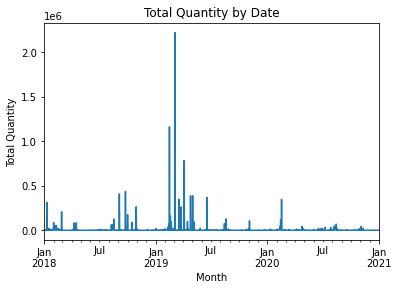

In [306]:
factOrder_df.DateOrderedKey =  pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m-%d')
#factOrder_df = factOrder_df[pd.to_datetime(factOrder_df['DateOrderedKey']).dt.strftime('%Y') >= '2019']

total_by_date = factOrder_df.groupby(pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m'))['QuantityOrdered'].sum().fillna(0)
total_by_date.plot()
plt.title('Total Quantity by Date')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.show()

# Preprocessing the dataset

In [307]:
article_dimension_df = pd.DataFrame(factOrder_df[article_dimension].dropna().unique(), columns=[article_dimension])
article_dimension_df

ArticleGenre
0             Övrigt
1   DRESSES LS WOVEN
2        SWEATSHIRTS
3            TEES LS
4            TEES SS
..               ...
79           Jackets
80         Postcards
81             Party
82             Shoes
83    JUMPSUIT WOVEN

[84 rows x 1 columns]

In [308]:
#factOrder_df = factOrder_df.groupby(['DateOrderedKey']).sum('QuantityOrdered').fillna(0)
factOrder_df = factOrder_df.groupby(['DateOrderedKey', article_dimension]).sum('QuantityOrdered').fillna(0)
factOrder_df = factOrder_df.reset_index()
factOrder_df = factOrder_df[['DateOrderedKey', 'QuantityOrdered', article_dimension]]

factOrder_df

DateOrderedKey  QuantityOrdered       ArticleGenre
0         2018-01-01             29.0            BEANIES
1         2018-01-01              2.0           BEDDINGS
2         2018-01-01              8.0            BODY LS
3         2018-01-01              2.0            BODY SS
4         2018-01-01              1.0          BODY WRAP
...              ...              ...                ...
48444     2021-01-01              3.0  TROUSERS UNPADDED
48445     2021-01-01              1.0       TROUSERS WCT
48446     2021-01-01              3.0     TROUSERS WOVEN
48447     2021-01-01              3.0          UNDERWEAR
48448     2021-01-01              1.0            UV TOPS

[48449 rows x 3 columns]

In [309]:
# Creating the common function for splitting the dataset into test and train samples
def CreateSplitTestAndTrainData(df_model):
    # Splitting the dataset into training and test    
    train = df_model[pd.to_datetime(df_model['ds']).dt.strftime('%Y') <= train_end_year]
    test = df_model[pd.to_datetime(df_model['ds']).dt.strftime('%Y') > train_end_year]
        
    return train, test

In [310]:
def CreateModel(train):
    
    model = Prophet(weekly_seasonality=False)
    #model = Prophet()
    
    # Enable monthly seasonality
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
       
    # Fitting the model with the training dataset
    model.fit(train)
    
    return model

In [311]:
def ModelPrediction(model, _article_dimension):
    # Create future dates for prediction
    future_dates = model.make_future_dataframe(periods=12, freq='MS')
  #  future_dates = model.make_future_dataframe(periods=365, freq='D')

    # Make predictions for future dates
    predictions = model.predict(future_dates)

    # Plot the prediction
    model.plot(predictions);
    
    plt.title(_article_dimension)
    plt.xlabel('Period')
    plt.ylabel('Total Quantity')
    plt.show()
    #print(predictions)
    
    return predictions
    
    # Plot the prediction components
   # model.plot_components(predictions);

Övrigt


22:55:31 - cmdstanpy - INFO - Chain [1] start processing
22:55:32 - cmdstanpy - INFO - Chain [1] done processing


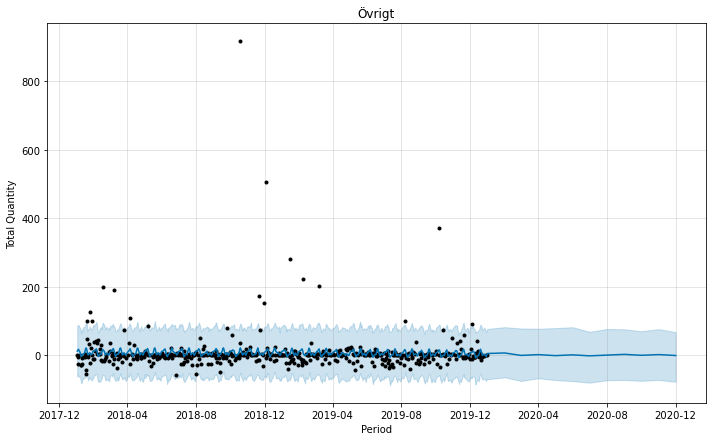

DRESSES LS WOVEN


22:55:33 - cmdstanpy - INFO - Chain [1] start processing
22:55:33 - cmdstanpy - INFO - Chain [1] done processing


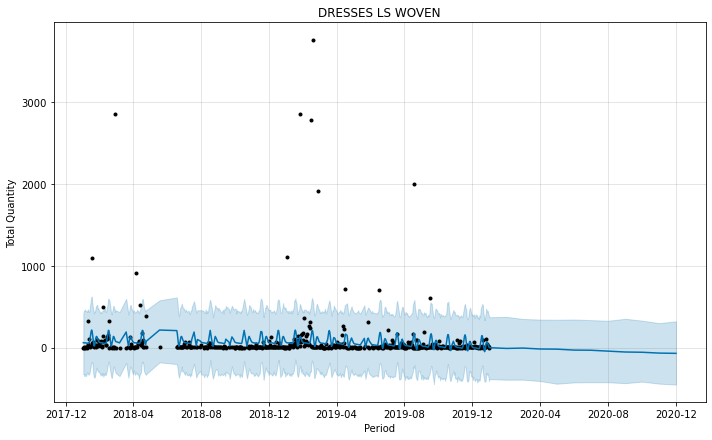

SWEATSHIRTS


22:55:34 - cmdstanpy - INFO - Chain [1] start processing
22:55:34 - cmdstanpy - INFO - Chain [1] done processing


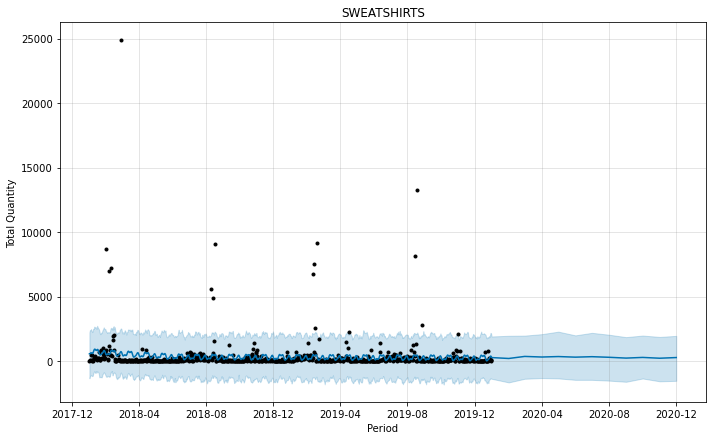

TEES LS


22:55:36 - cmdstanpy - INFO - Chain [1] start processing
22:55:36 - cmdstanpy - INFO - Chain [1] done processing


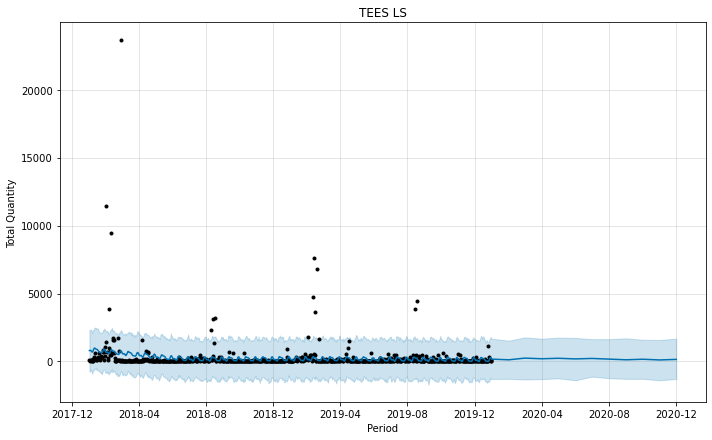

TEES SS


22:55:37 - cmdstanpy - INFO - Chain [1] start processing
22:55:37 - cmdstanpy - INFO - Chain [1] done processing


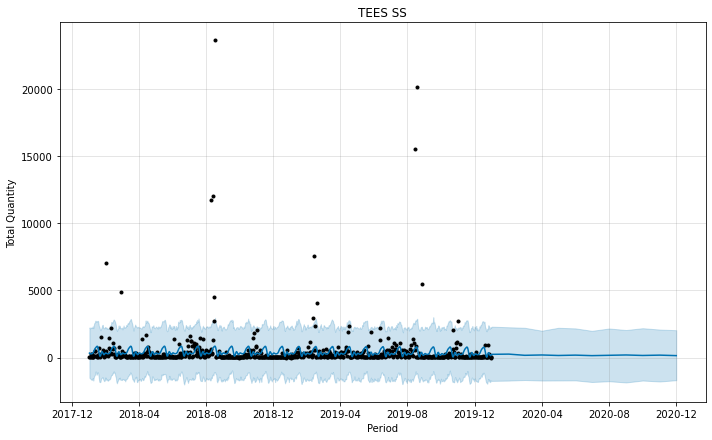

DRESSES LS


22:55:39 - cmdstanpy - INFO - Chain [1] start processing
22:55:39 - cmdstanpy - INFO - Chain [1] done processing


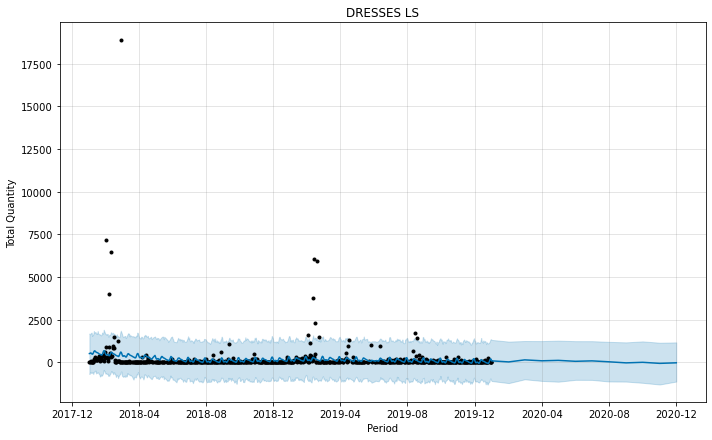

LEGGINGS


22:55:40 - cmdstanpy - INFO - Chain [1] start processing
22:55:41 - cmdstanpy - INFO - Chain [1] done processing


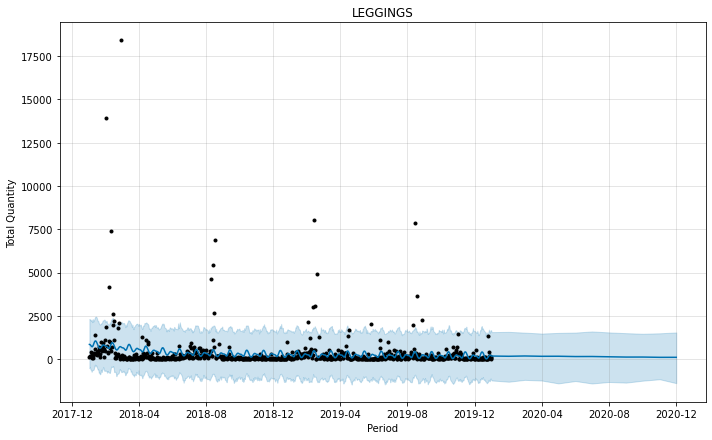

DRESSES SS


22:55:42 - cmdstanpy - INFO - Chain [1] start processing
22:55:42 - cmdstanpy - INFO - Chain [1] done processing


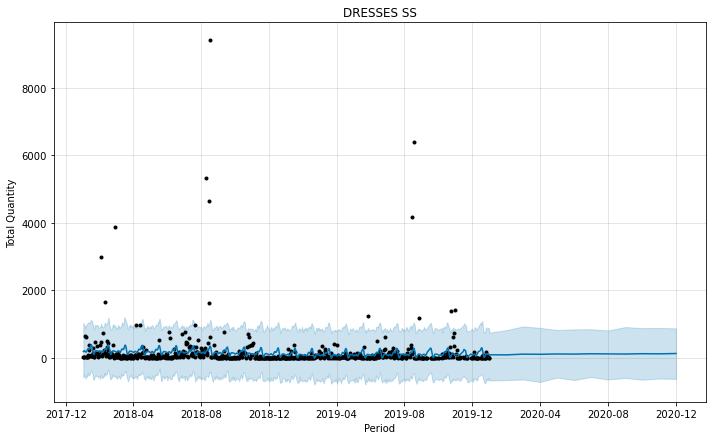

BEANIES


22:55:43 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing


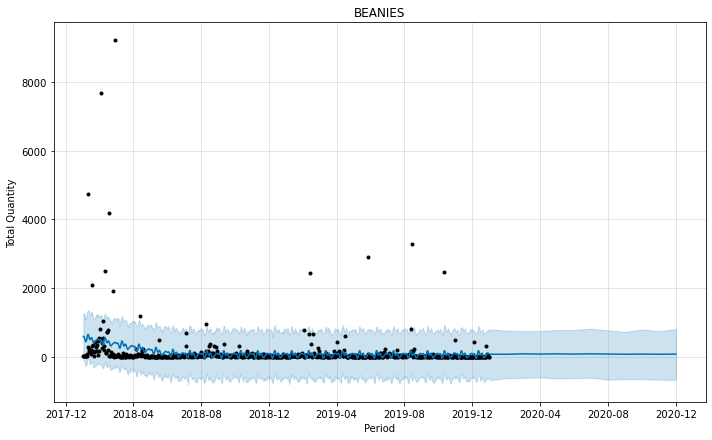

JACKETS UNPADDED


22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1] done processing


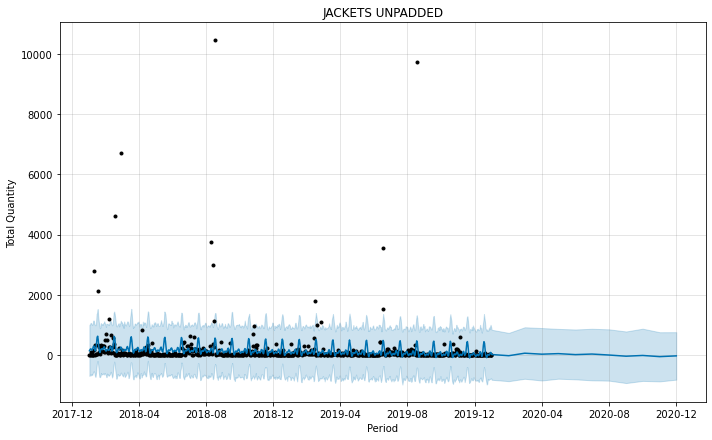

LEGGINGS NB


22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing


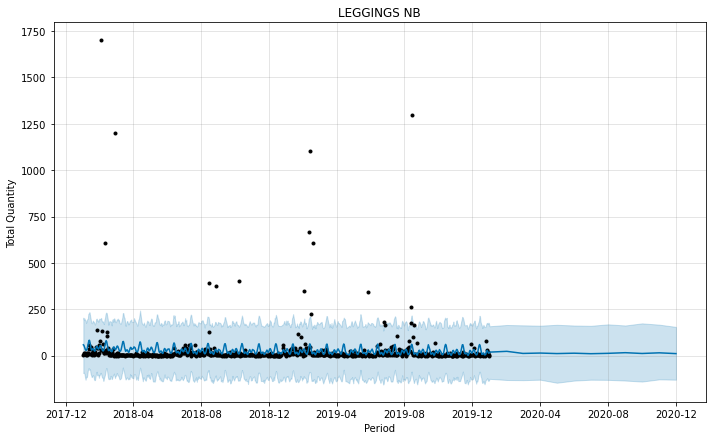

SKIRTS


22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:48 - cmdstanpy - INFO - Chain [1] done processing


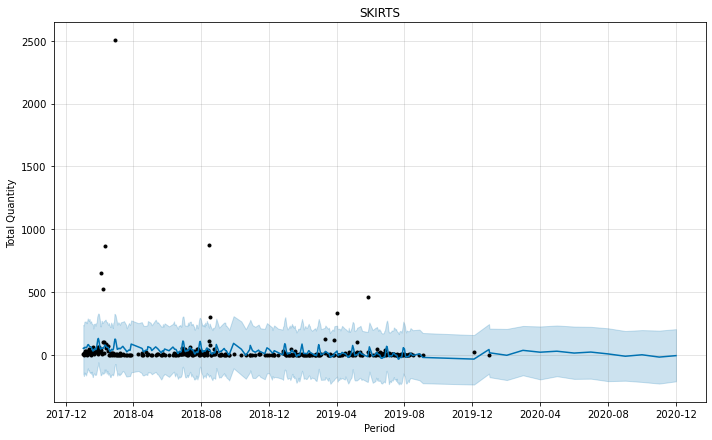

22:55:49 - cmdstanpy - INFO - Chain [1] start processing


Dungaree


22:55:49 - cmdstanpy - INFO - Chain [1] done processing


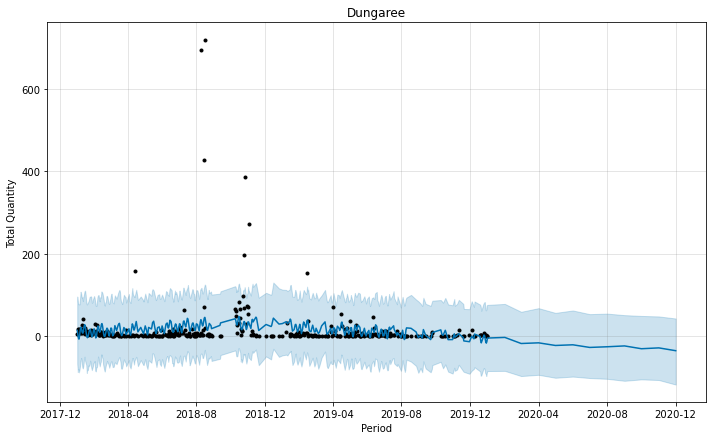

ONESIES


22:55:50 - cmdstanpy - INFO - Chain [1] start processing
22:55:50 - cmdstanpy - INFO - Chain [1] done processing


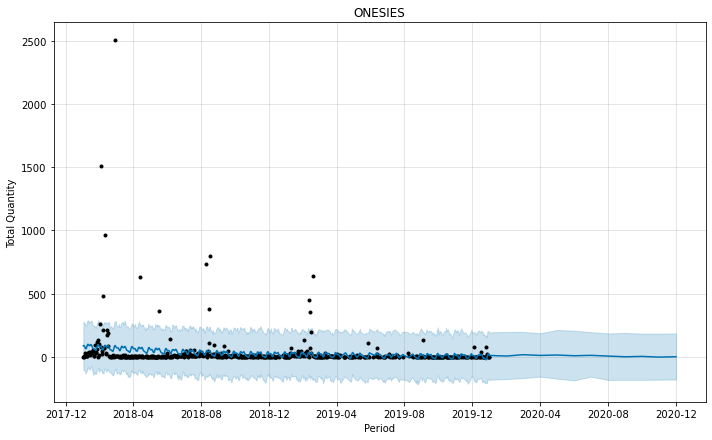

CAPS


22:55:52 - cmdstanpy - INFO - Chain [1] start processing
22:55:52 - cmdstanpy - INFO - Chain [1] done processing


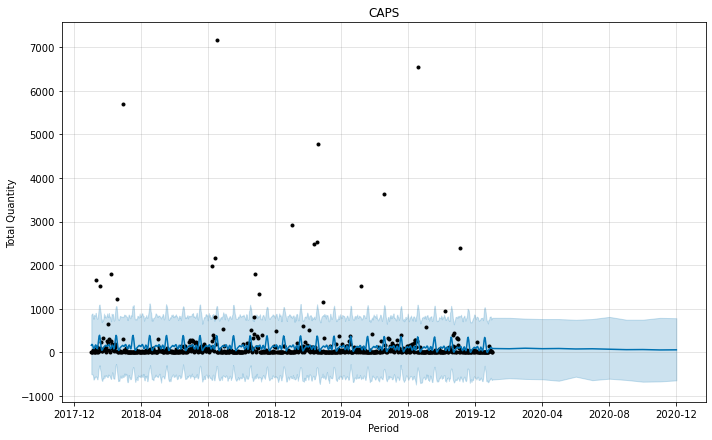

BODY LS


22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:53 - cmdstanpy - INFO - Chain [1] done processing


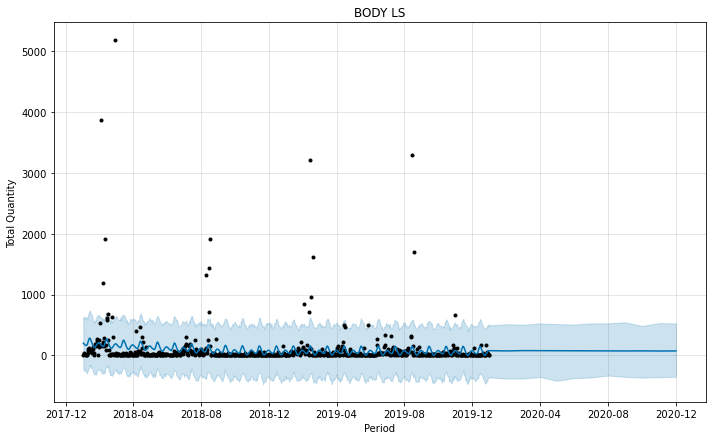

SHIRT/BLOUSE


22:55:54 - cmdstanpy - INFO - Chain [1] start processing
22:55:54 - cmdstanpy - INFO - Chain [1] done processing


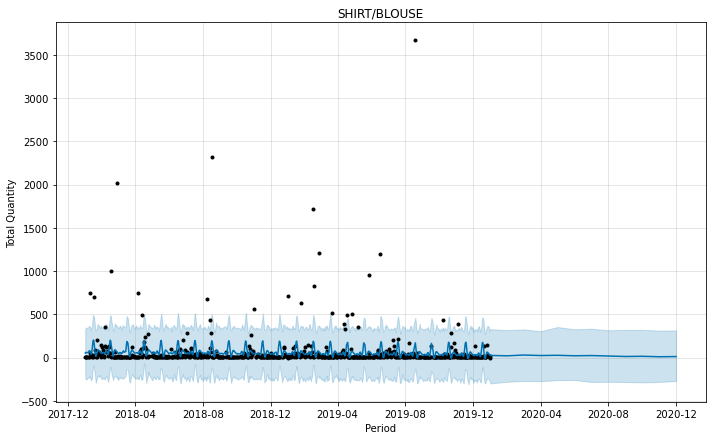

TROUSERS JERSEY


22:55:56 - cmdstanpy - INFO - Chain [1] start processing
22:55:56 - cmdstanpy - INFO - Chain [1] done processing


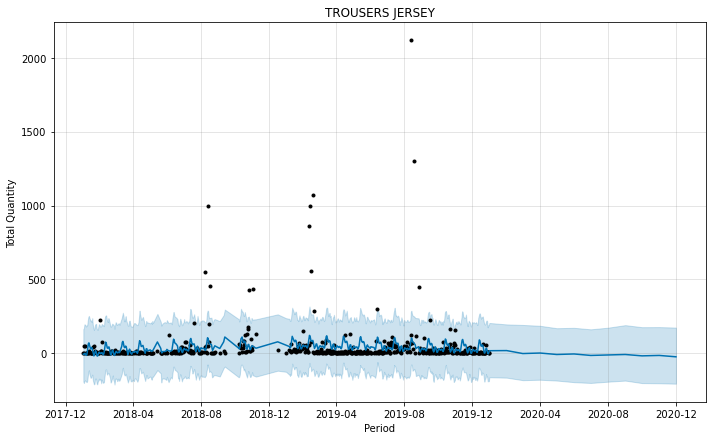

SWEATPANTS


22:55:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:58 - cmdstanpy - INFO - Chain [1] done processing


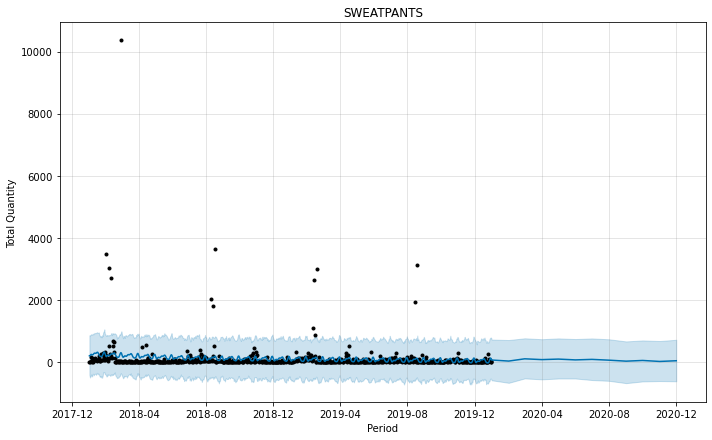

Jumpsuits Baby


22:55:59 - cmdstanpy - INFO - Chain [1] start processing
22:55:59 - cmdstanpy - INFO - Chain [1] done processing


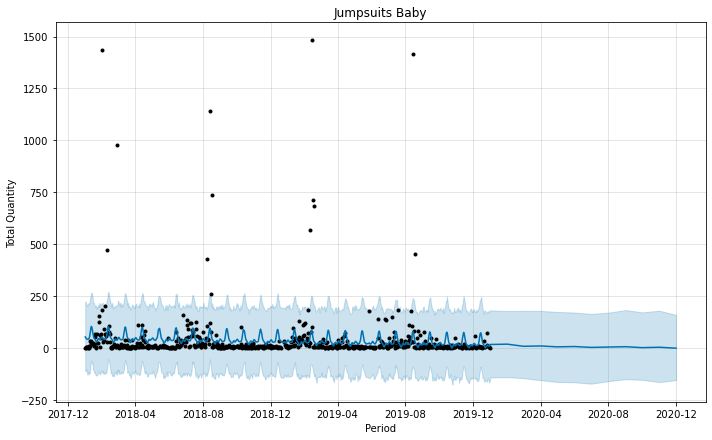

SWEATDRESSES


22:56:00 - cmdstanpy - INFO - Chain [1] start processing
22:56:00 - cmdstanpy - INFO - Chain [1] done processing


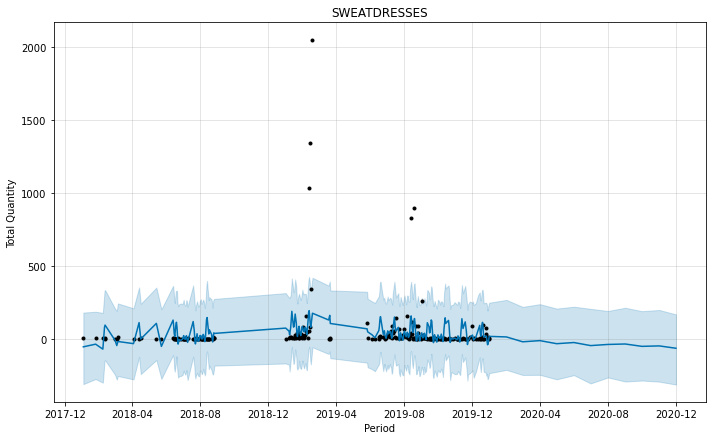

BODY WRAP


22:56:02 - cmdstanpy - INFO - Chain [1] start processing
22:56:02 - cmdstanpy - INFO - Chain [1] done processing


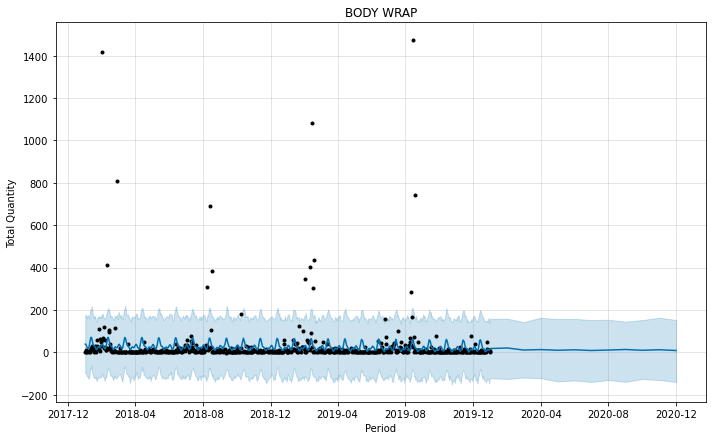

SWEATERS


22:56:03 - cmdstanpy - INFO - Chain [1] start processing
22:56:03 - cmdstanpy - INFO - Chain [1] done processing


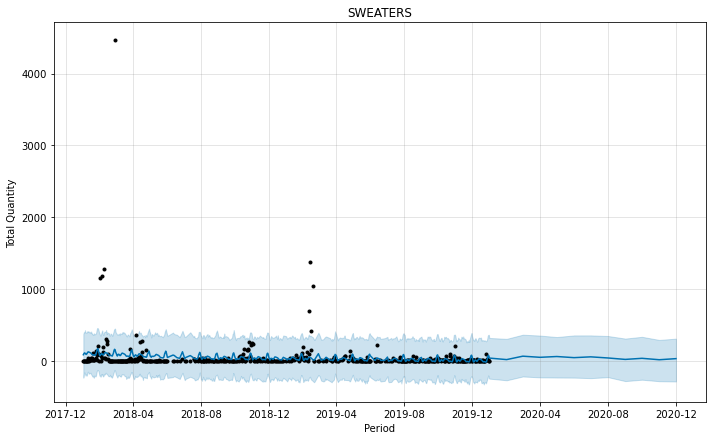

OVERALLS UNPADDED


22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:04 - cmdstanpy - INFO - Chain [1] done processing


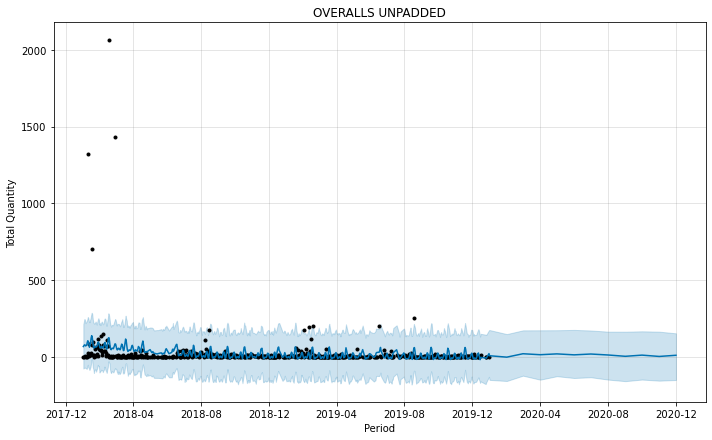

TIGHTS


22:56:06 - cmdstanpy - INFO - Chain [1] start processing
22:56:06 - cmdstanpy - INFO - Chain [1] done processing


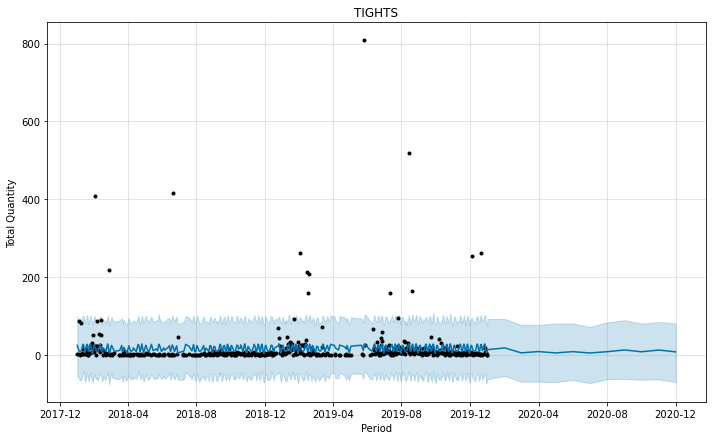

BODY SS


22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing


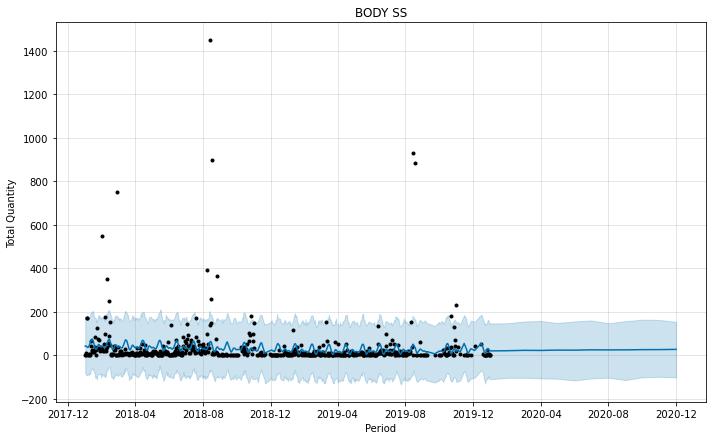

JACKETS PADDED


22:56:08 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing


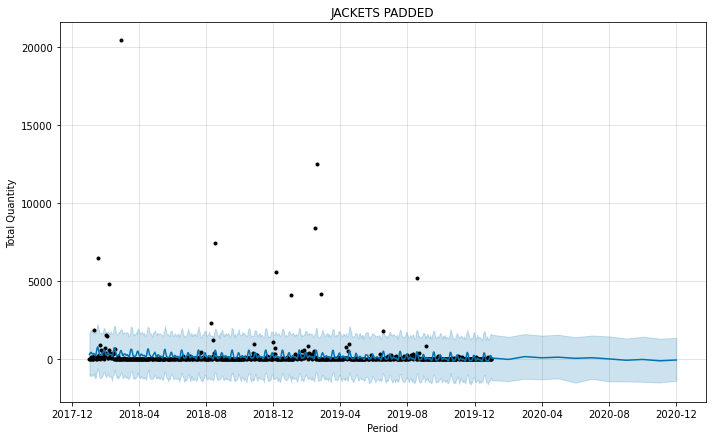

SKIRTS WOVEN


22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing


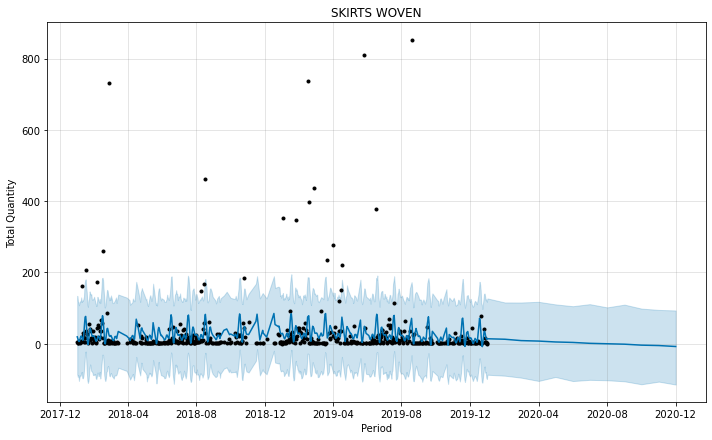

BAGS


22:56:12 - cmdstanpy - INFO - Chain [1] start processing
22:56:12 - cmdstanpy - INFO - Chain [1] done processing


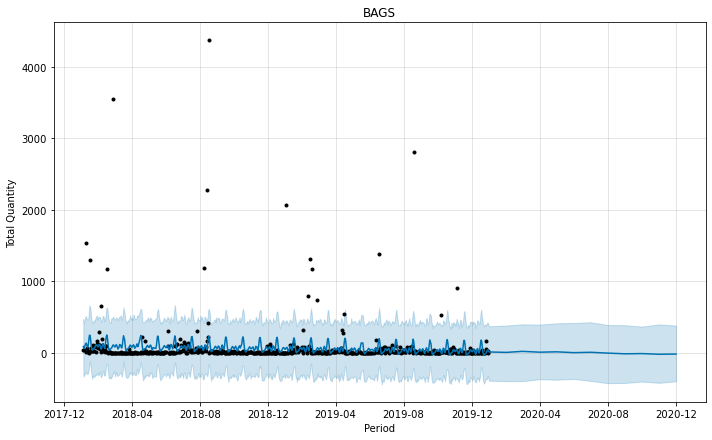

SOCKS


22:56:13 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing


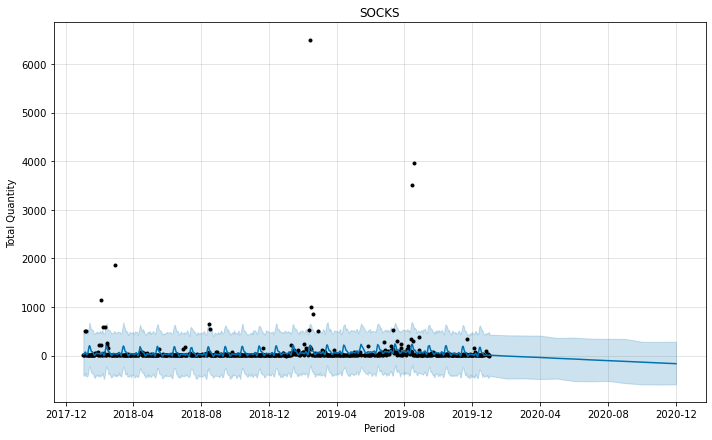

FLEECE


22:56:15 - cmdstanpy - INFO - Chain [1] start processing
22:56:15 - cmdstanpy - INFO - Chain [1] done processing


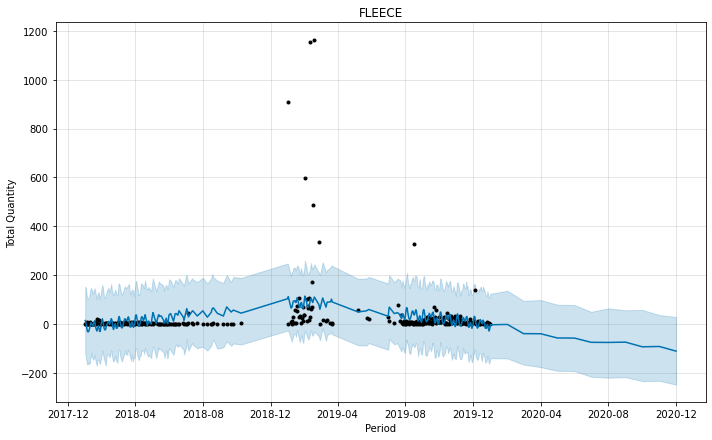

22:56:16 - cmdstanpy - INFO - Chain [1] start processing


OTHER HOME


22:56:16 - cmdstanpy - INFO - Chain [1] done processing


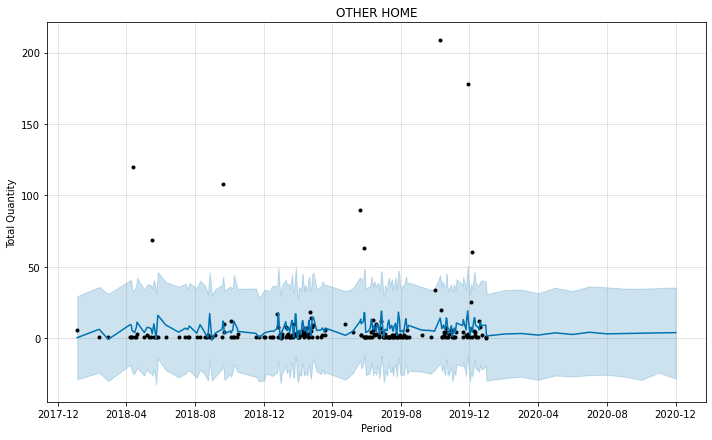

SWIMSUITS


22:56:17 - cmdstanpy - INFO - Chain [1] start processing
22:56:17 - cmdstanpy - INFO - Chain [1] done processing


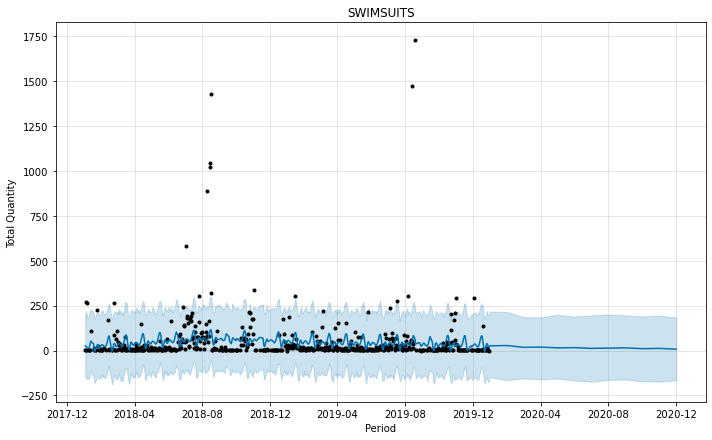

GLOVES


22:56:18 - cmdstanpy - INFO - Chain [1] start processing
22:56:18 - cmdstanpy - INFO - Chain [1] done processing


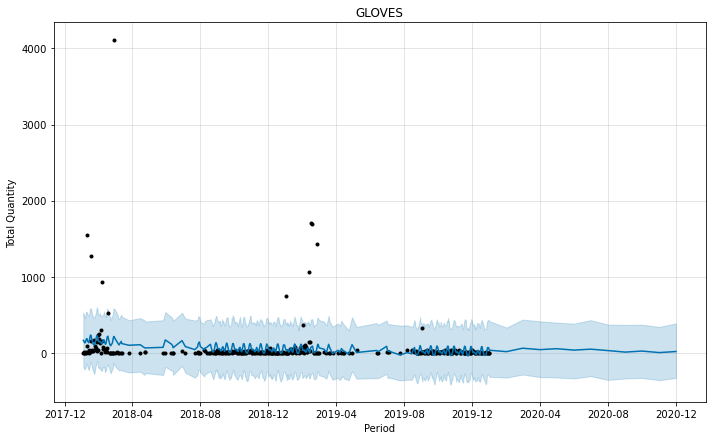

TROUSERS WOVEN


22:56:19 - cmdstanpy - INFO - Chain [1] start processing
22:56:19 - cmdstanpy - INFO - Chain [1] done processing


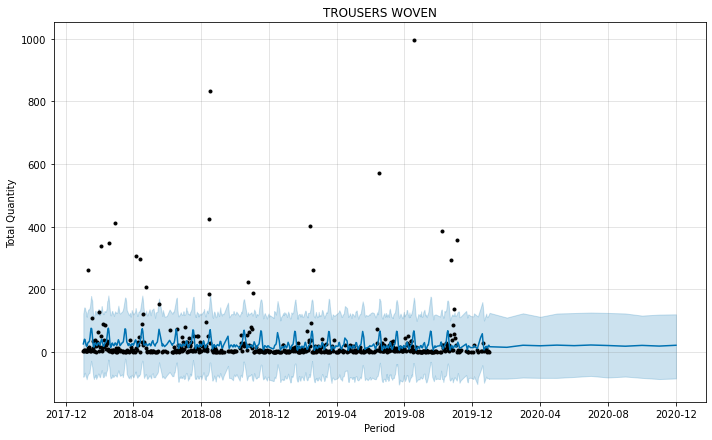

BEDDINGS


22:56:21 - cmdstanpy - INFO - Chain [1] start processing
22:56:21 - cmdstanpy - INFO - Chain [1] done processing


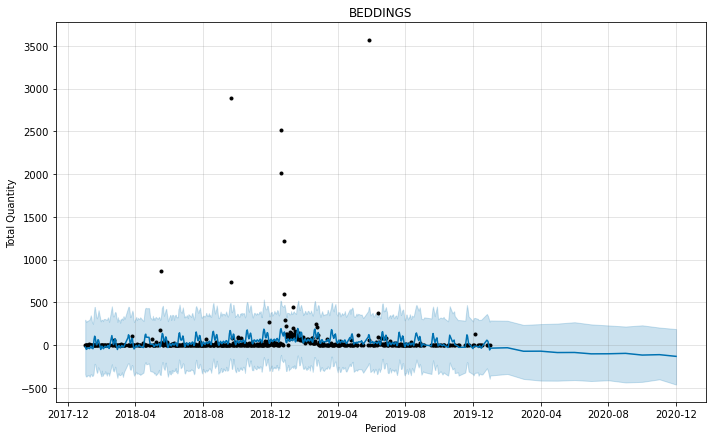

Giftbox


22:56:22 - cmdstanpy - INFO - Chain [1] start processing
22:56:22 - cmdstanpy - INFO - Chain [1] done processing


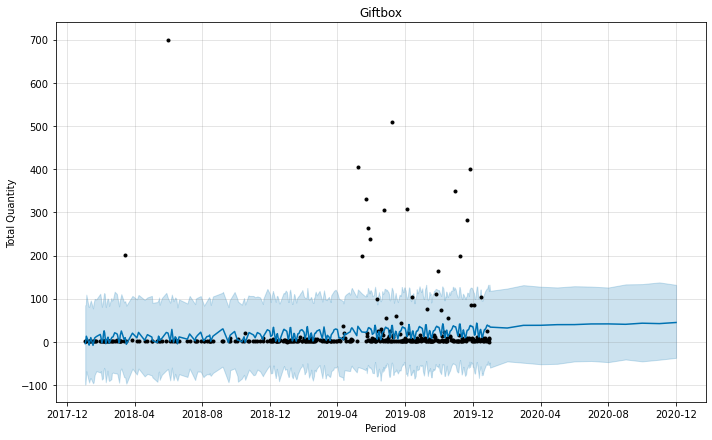

CARDIGANS


22:56:24 - cmdstanpy - INFO - Chain [1] start processing
22:56:24 - cmdstanpy - INFO - Chain [1] done processing


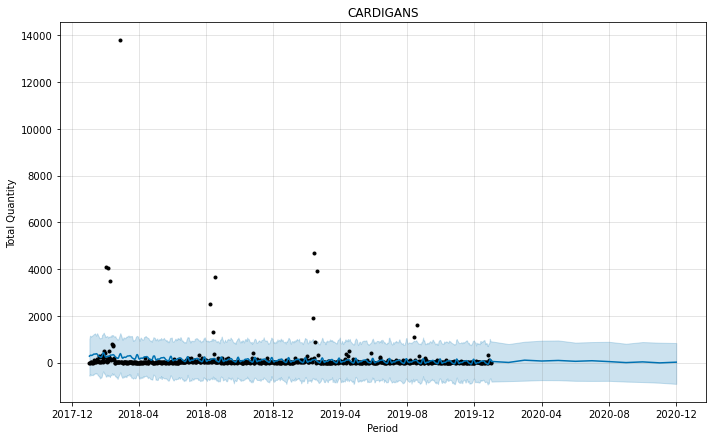

22:56:25 - cmdstanpy - INFO - Chain [1] start processing


SUNGLASSES


22:56:26 - cmdstanpy - INFO - Chain [1] done processing


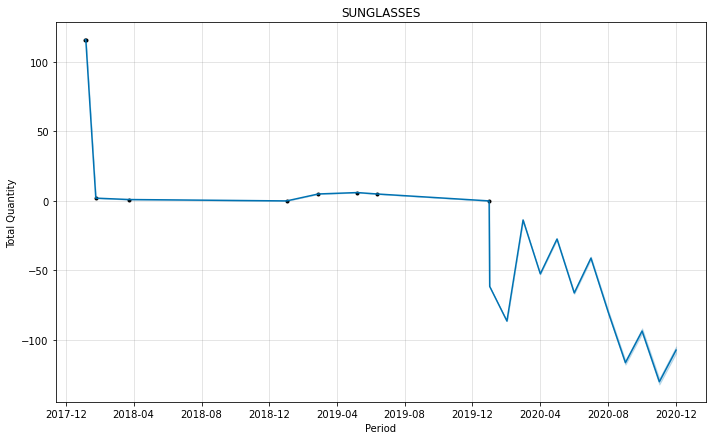

DRESSES STRAP


22:56:27 - cmdstanpy - INFO - Chain [1] start processing
22:56:27 - cmdstanpy - INFO - Chain [1] done processing


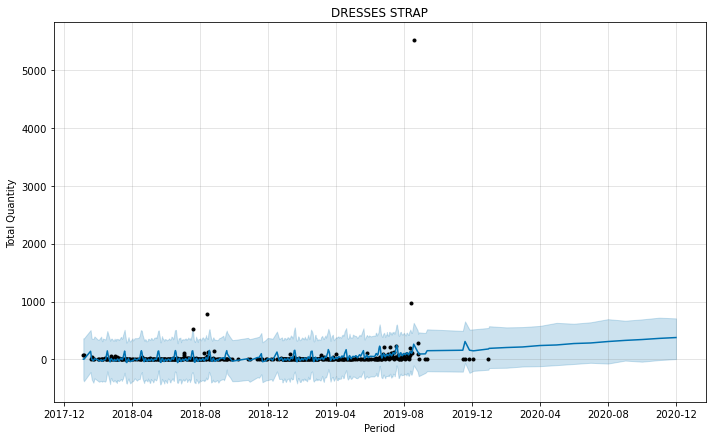

UV TOPS


22:56:28 - cmdstanpy - INFO - Chain [1] start processing
22:56:28 - cmdstanpy - INFO - Chain [1] done processing


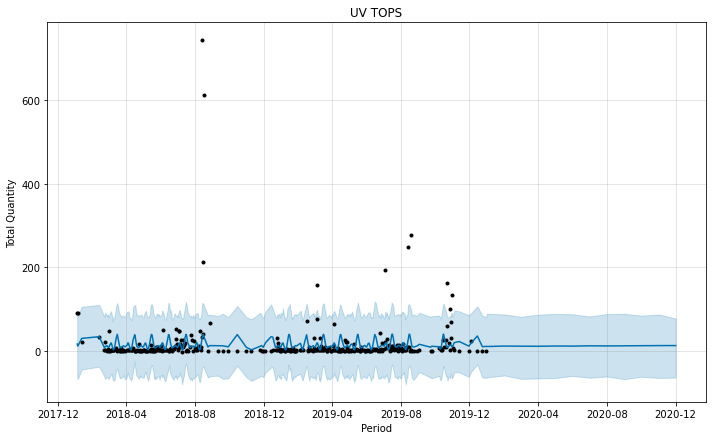

JUMPSUITS


22:56:29 - cmdstanpy - INFO - Chain [1] start processing
22:56:29 - cmdstanpy - INFO - Chain [1] done processing


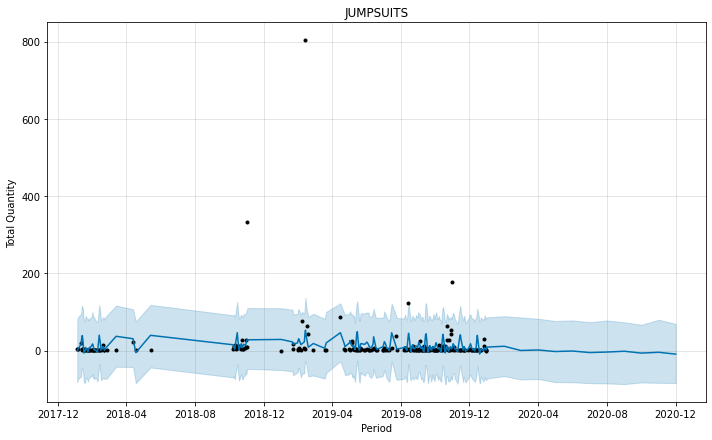

SHORTS


22:56:30 - cmdstanpy - INFO - Chain [1] start processing
22:56:30 - cmdstanpy - INFO - Chain [1] done processing


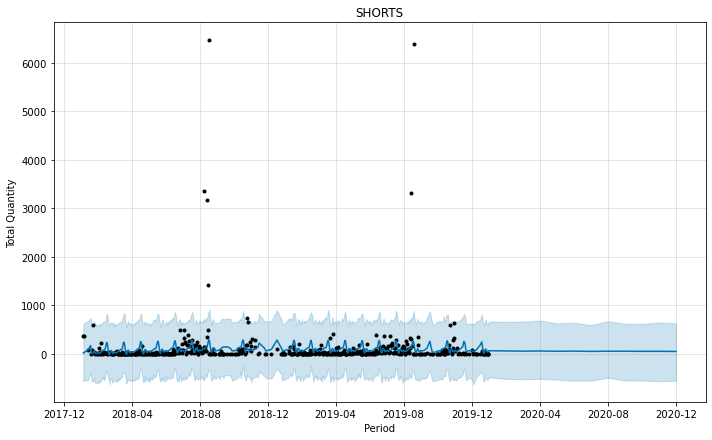

TANKS


22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] done processing


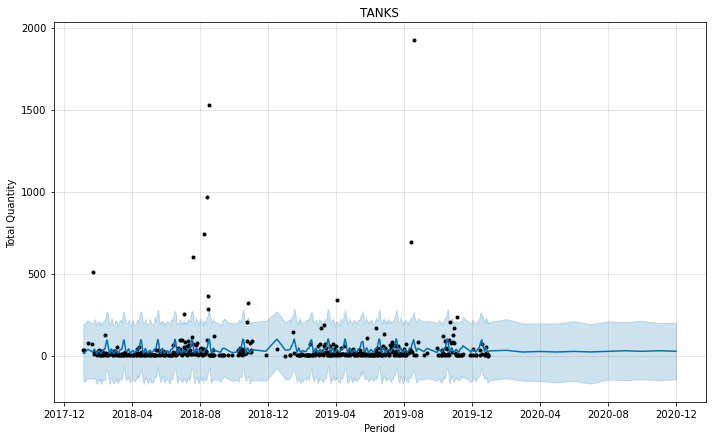

SWIMSHORTS


22:56:33 - cmdstanpy - INFO - Chain [1] start processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing


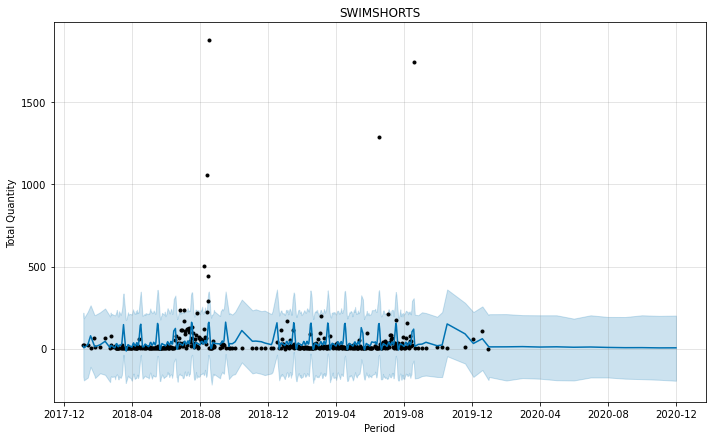

RAIN & SUN HATS


22:56:34 - cmdstanpy - INFO - Chain [1] start processing
22:56:35 - cmdstanpy - INFO - Chain [1] done processing


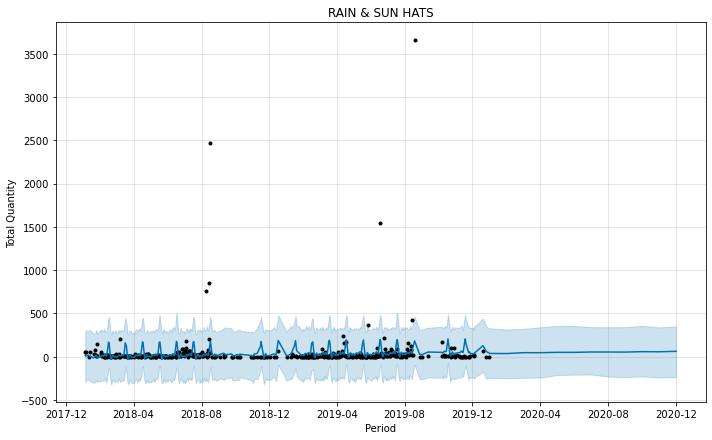

SWIMPANTS


22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing


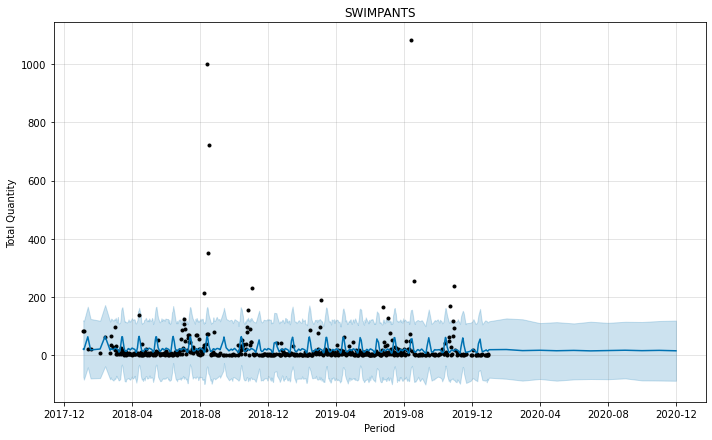

OVERALLS PADDED


22:56:37 - cmdstanpy - INFO - Chain [1] start processing
22:56:37 - cmdstanpy - INFO - Chain [1] done processing


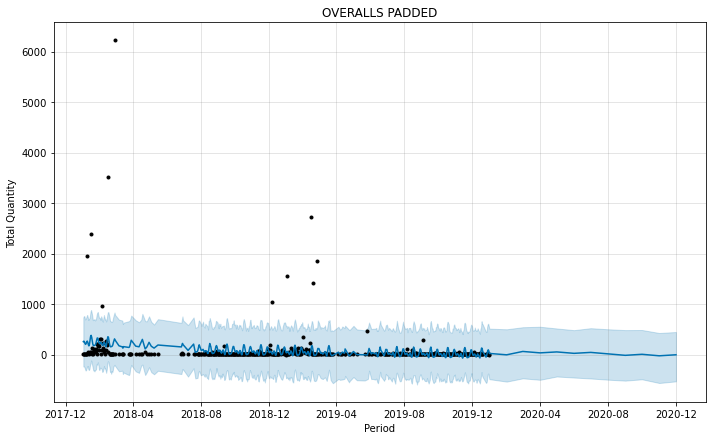

OTHER ACCESSORIES


22:56:38 - cmdstanpy - INFO - Chain [1] start processing
22:56:39 - cmdstanpy - INFO - Chain [1] done processing


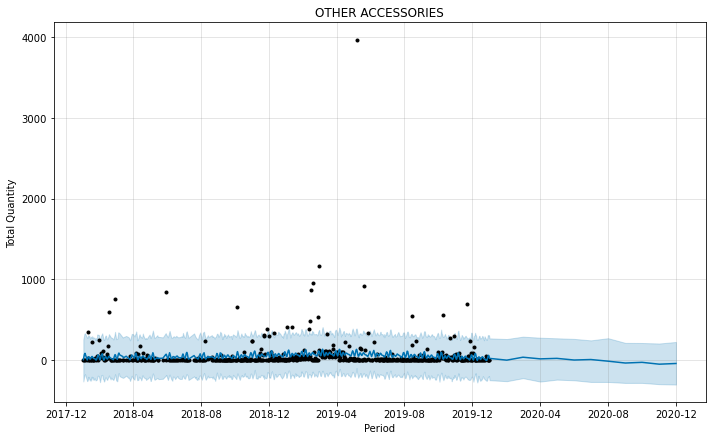

22:56:40 - cmdstanpy - INFO - Chain [1] start processing


SHOES


22:56:40 - cmdstanpy - INFO - Chain [1] done processing


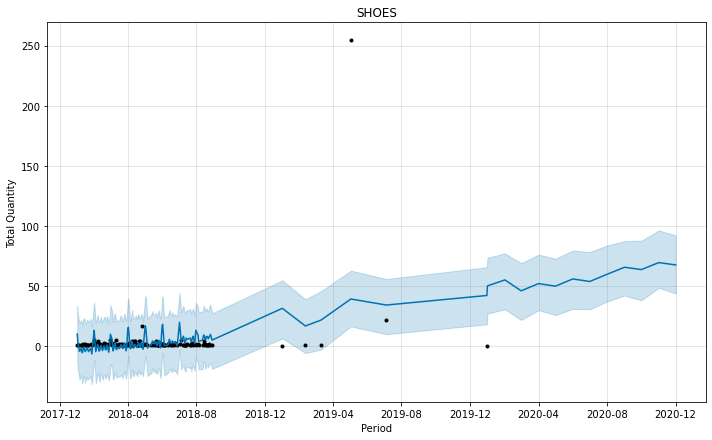

TROUSERS PADDED


22:56:41 - cmdstanpy - INFO - Chain [1] start processing
22:56:41 - cmdstanpy - INFO - Chain [1] done processing


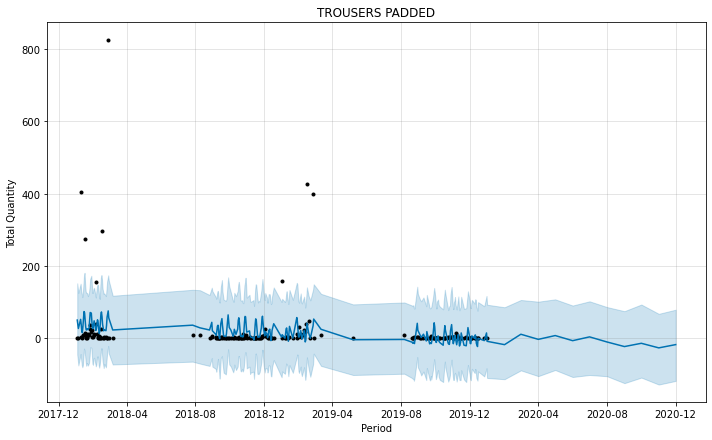

DRESSES SS WOVEN


22:56:42 - cmdstanpy - INFO - Chain [1] start processing
22:56:42 - cmdstanpy - INFO - Chain [1] done processing


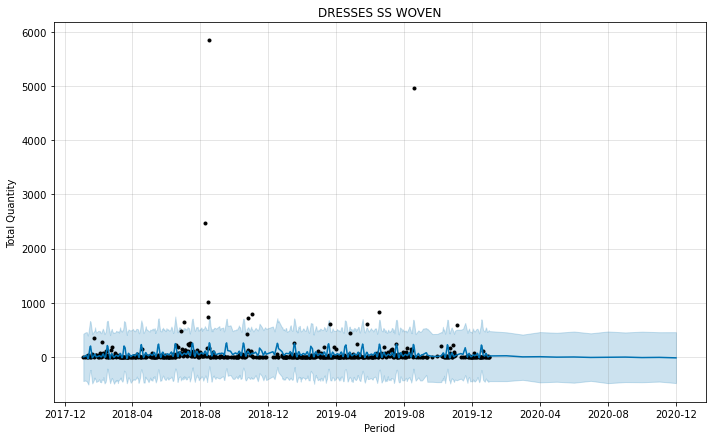

SCARVES/BIBS


22:56:44 - cmdstanpy - INFO - Chain [1] start processing
22:56:44 - cmdstanpy - INFO - Chain [1] done processing


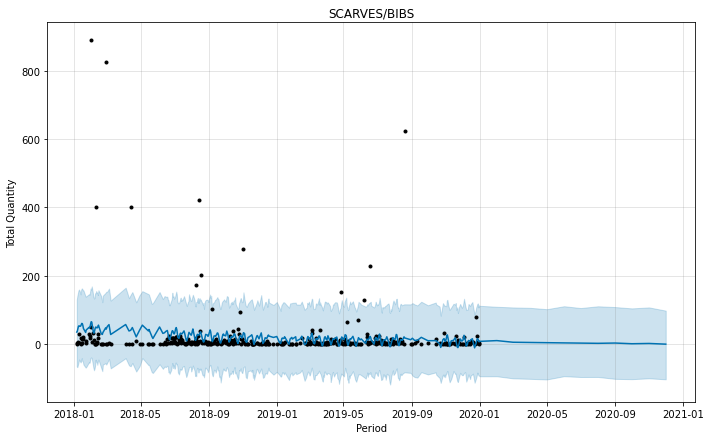

BABY BOOTS


22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] done processing


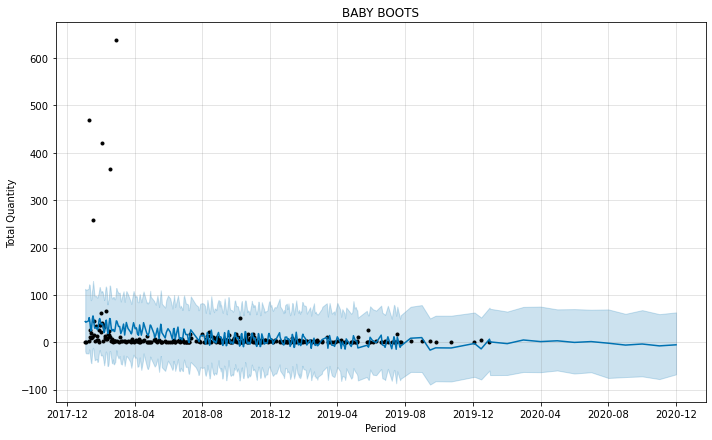

TROUSERS UNPADDED


22:56:46 - cmdstanpy - INFO - Chain [1] start processing
22:56:46 - cmdstanpy - INFO - Chain [1] done processing


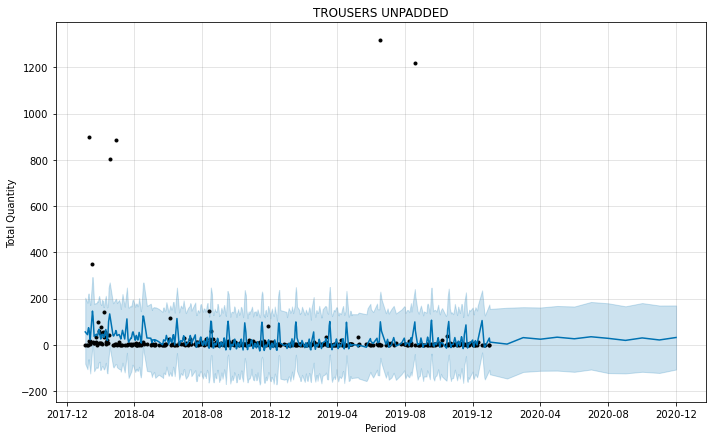

22:56:47 - cmdstanpy - INFO - Chain [1] start processing


DENIM


22:56:47 - cmdstanpy - INFO - Chain [1] done processing


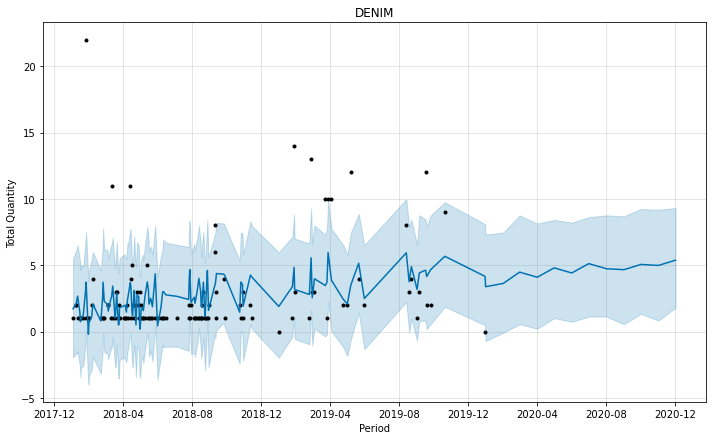

Summersuit


22:56:48 - cmdstanpy - INFO - Chain [1] start processing
22:56:49 - cmdstanpy - INFO - Chain [1] done processing


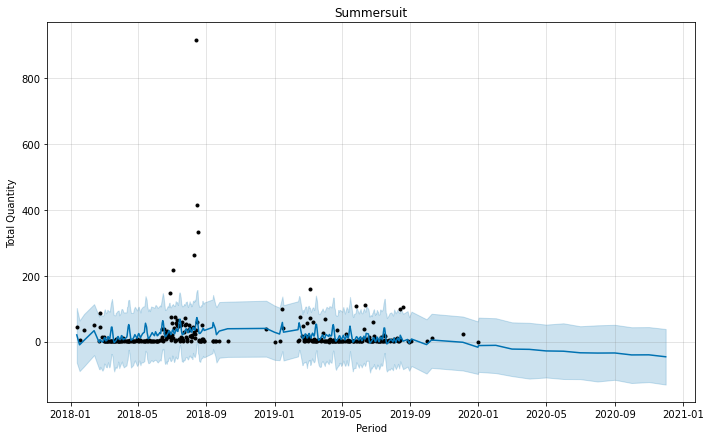

UV SUITS


22:56:50 - cmdstanpy - INFO - Chain [1] start processing
22:56:50 - cmdstanpy - INFO - Chain [1] done processing


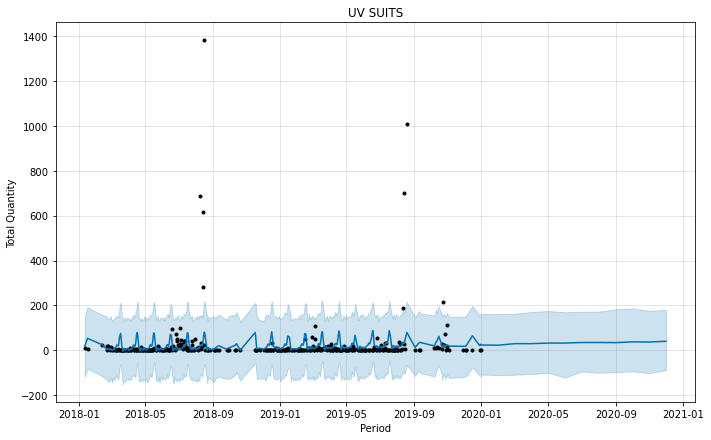

BABY KIT


22:56:51 - cmdstanpy - INFO - Chain [1] start processing
22:56:51 - cmdstanpy - INFO - Chain [1] done processing


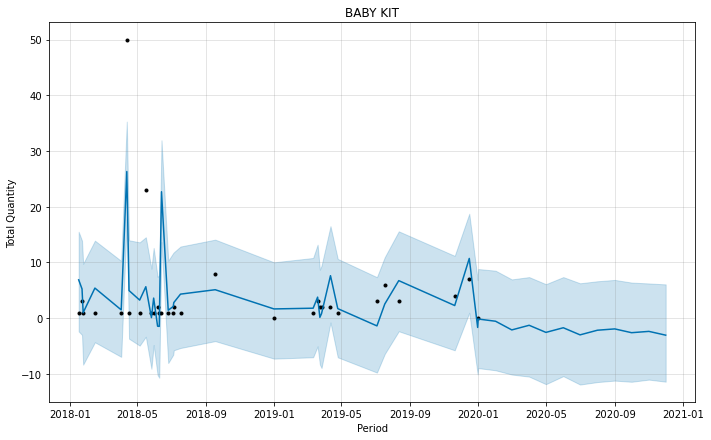

BATH


22:56:52 - cmdstanpy - INFO - Chain [1] start processing
22:56:52 - cmdstanpy - INFO - Chain [1] done processing


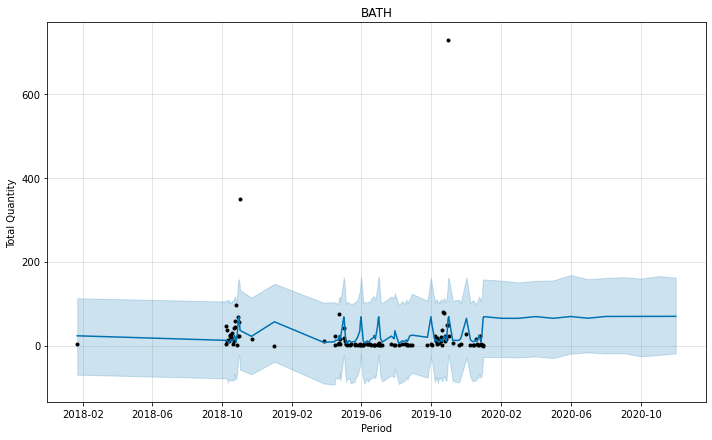

22:56:53 - cmdstanpy - INFO - Chain [1] start processing


Jacket


22:56:53 - cmdstanpy - INFO - Chain [1] done processing


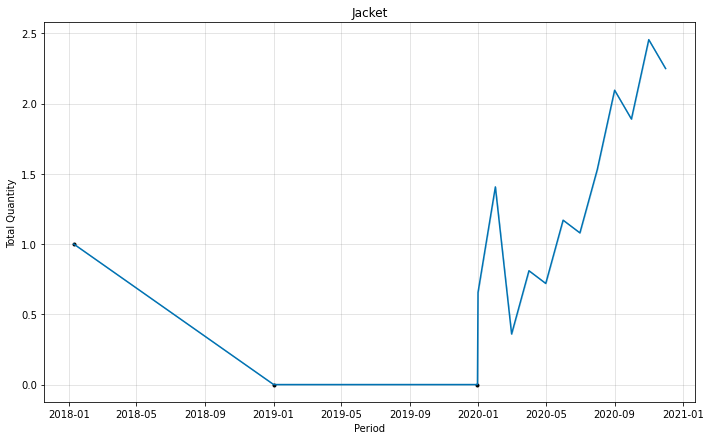

BODY WOVEN


22:56:54 - cmdstanpy - INFO - Chain [1] start processing
22:56:54 - cmdstanpy - INFO - Chain [1] done processing


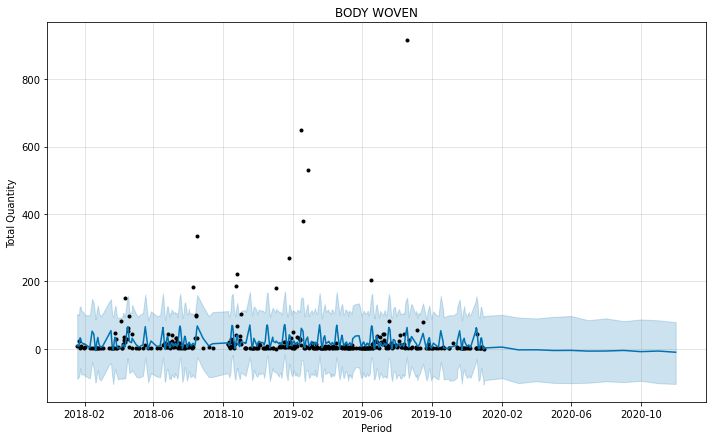

SHORTS WOVEN


22:56:56 - cmdstanpy - INFO - Chain [1] start processing
22:56:56 - cmdstanpy - INFO - Chain [1] done processing


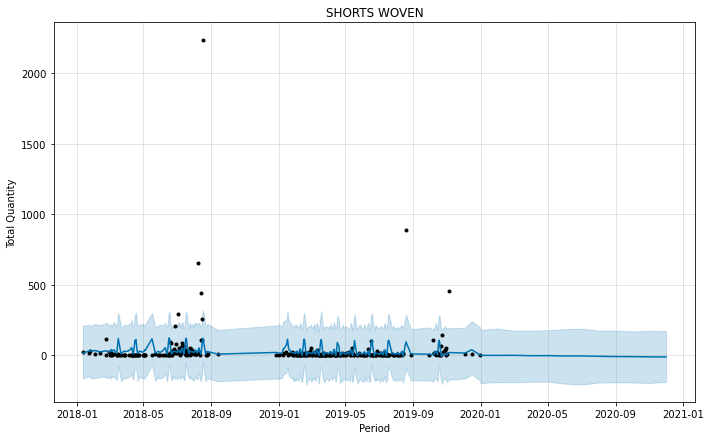

22:56:57 - cmdstanpy - INFO - Chain [1] start processing


PLAYSUIT


22:56:57 - cmdstanpy - INFO - Chain [1] done processing


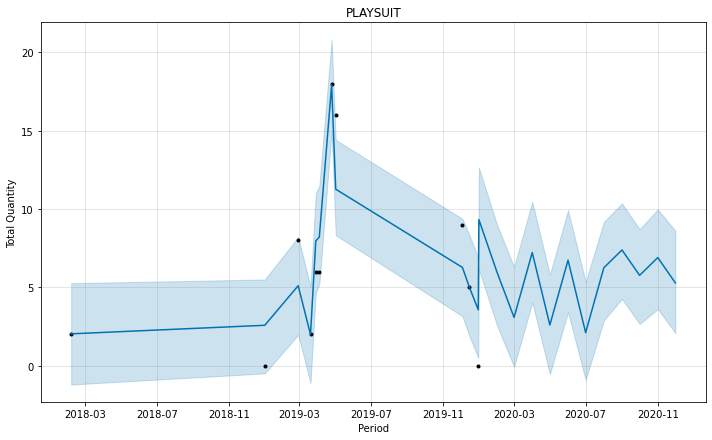

22:56:58 - cmdstanpy - INFO - Chain [1] start processing


OUTERWEAR


22:56:58 - cmdstanpy - INFO - Chain [1] done processing


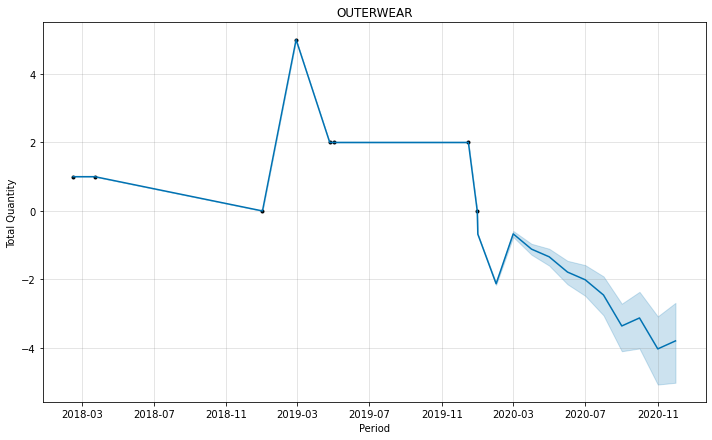

22:56:59 - cmdstanpy - INFO - Chain [1] start processing


INTERIOR


22:57:04 - cmdstanpy - INFO - Chain [1] done processing


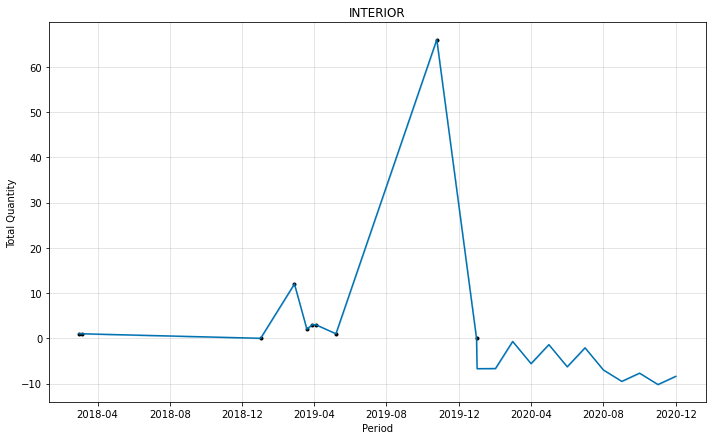

22:57:05 - cmdstanpy - INFO - Chain [1] start processing


ROBES


22:57:05 - cmdstanpy - INFO - Chain [1] done processing


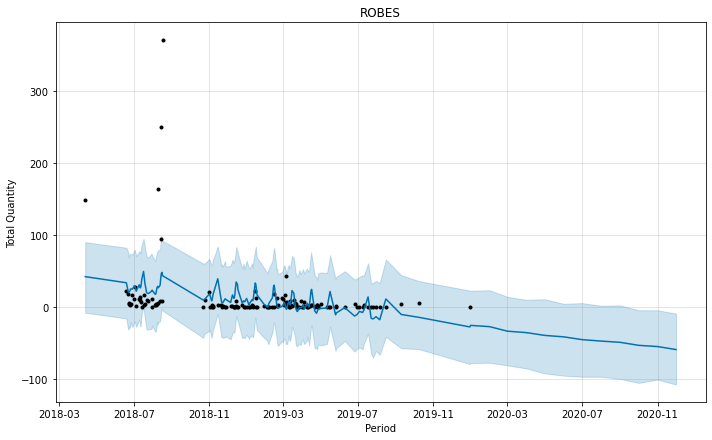

UNDERWEAR


22:57:06 - cmdstanpy - INFO - Chain [1] start processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing


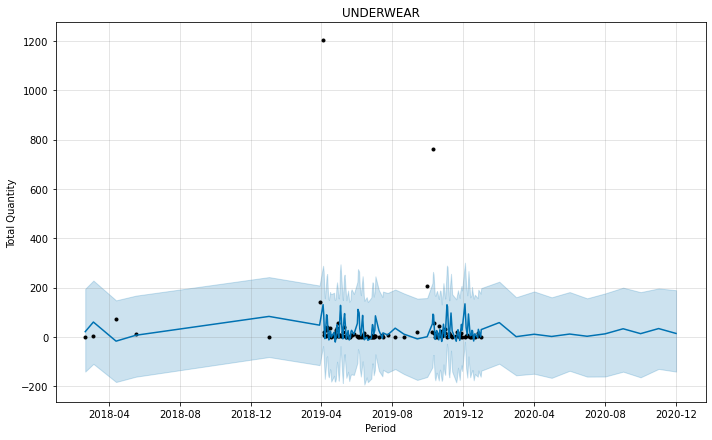

TOP WCT


22:57:08 - cmdstanpy - INFO - Chain [1] start processing
22:57:08 - cmdstanpy - INFO - Chain [1] done processing


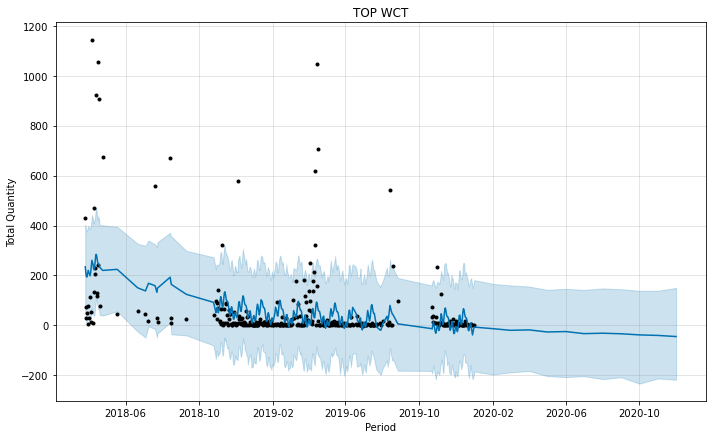

TROUSERS WCT


22:57:09 - cmdstanpy - INFO - Chain [1] start processing
22:57:09 - cmdstanpy - INFO - Chain [1] done processing


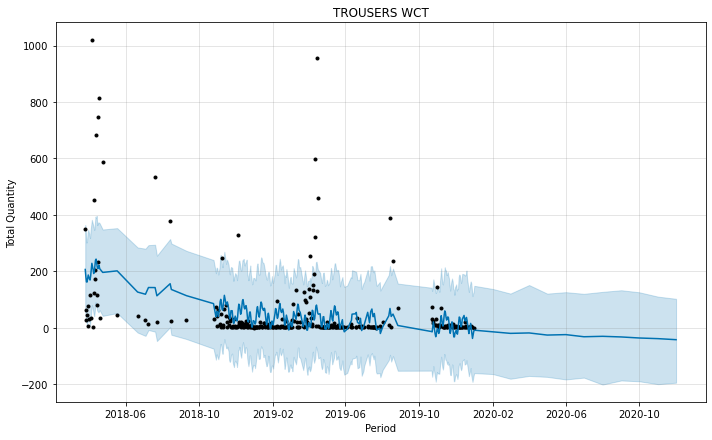

22:57:10 - cmdstanpy - INFO - Chain [1] start processing


TOP


22:57:10 - cmdstanpy - INFO - Chain [1] done processing


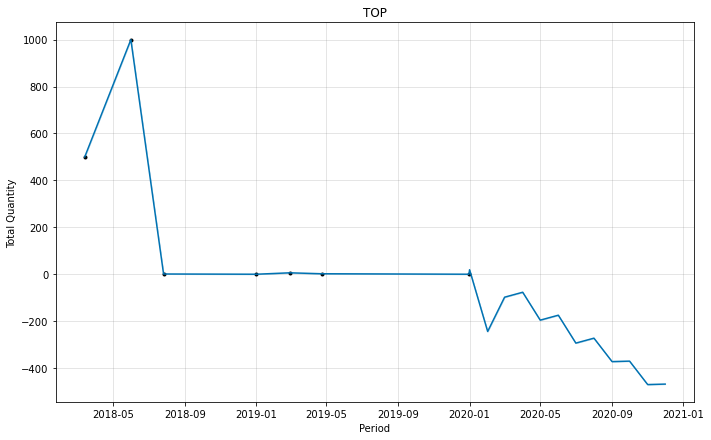

OTH


22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:13 - cmdstanpy - INFO - Chain [1] done processing


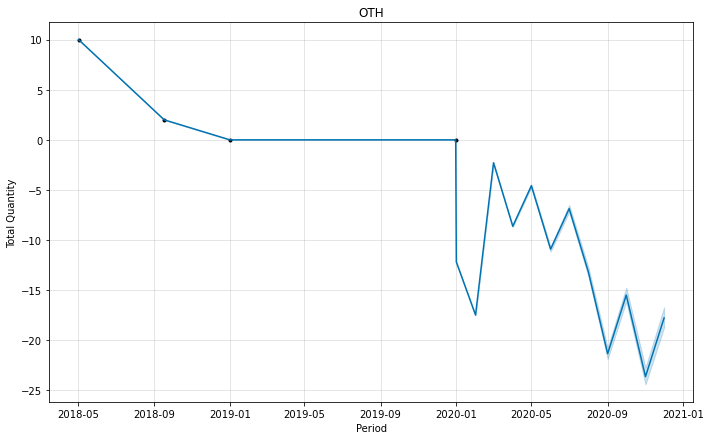

22:57:14 - cmdstanpy - INFO - Chain [1] start processing


Caps


22:57:14 - cmdstanpy - INFO - Chain [1] done processing


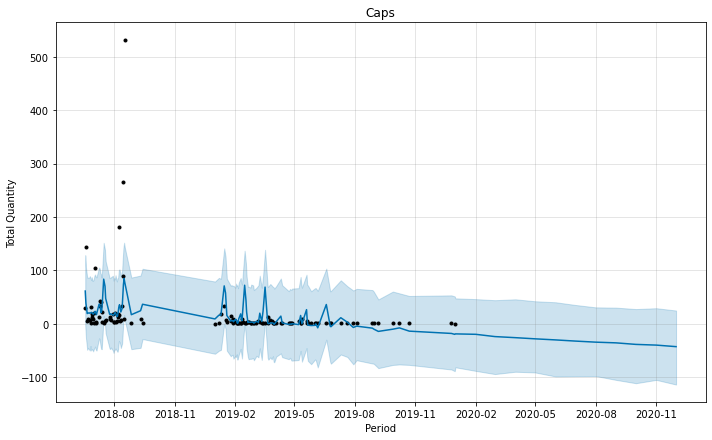

KNITTED HATS


22:57:15 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing


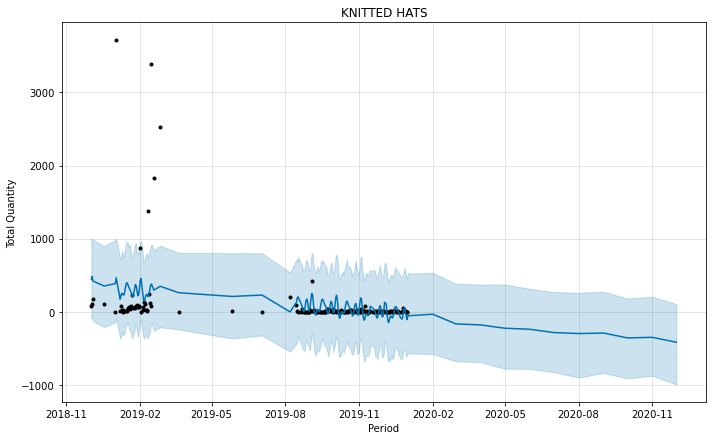

22:57:16 - cmdstanpy - INFO - Chain [1] start processing


BEANIE BABY


22:57:16 - cmdstanpy - INFO - Chain [1] done processing


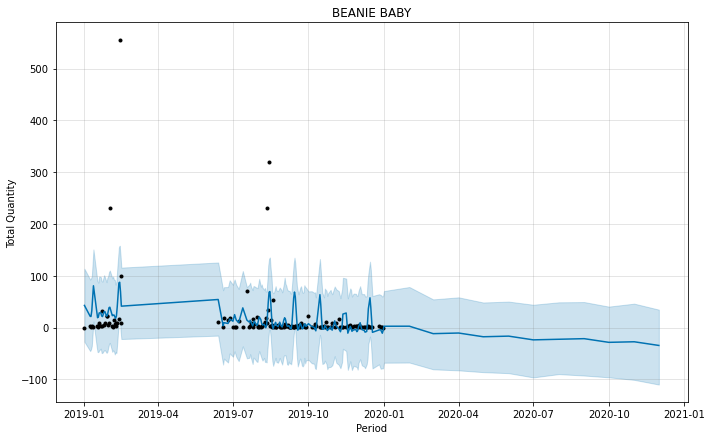

22:57:17 - cmdstanpy - INFO - Chain [1] start processing


HOME


22:57:17 - cmdstanpy - INFO - Chain [1] done processing


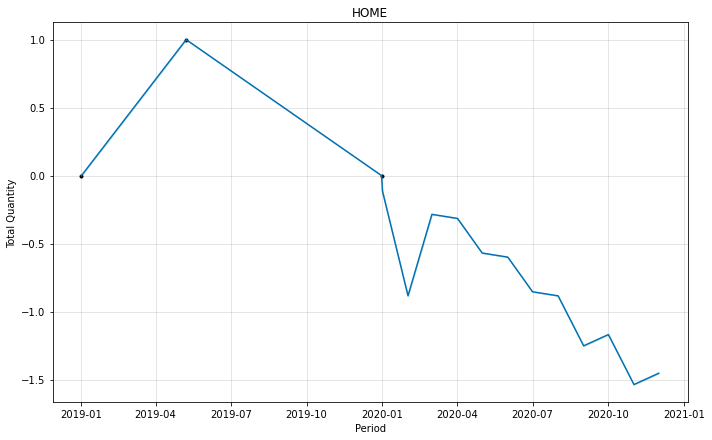

22:57:18 - cmdstanpy - INFO - Chain [1] start processing


Paperbags store material


22:57:18 - cmdstanpy - INFO - Chain [1] done processing


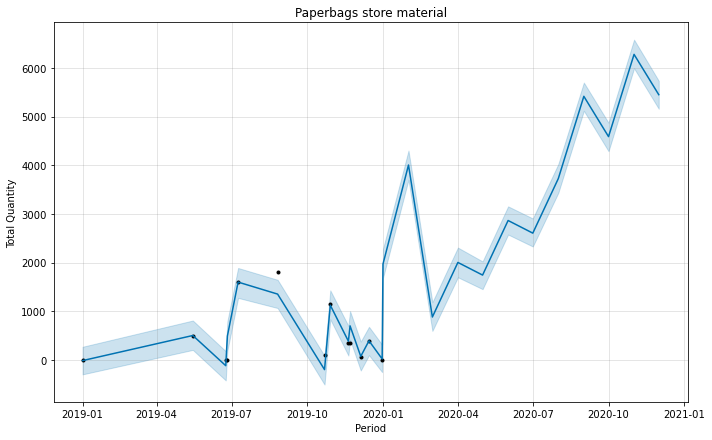

22:57:19 - cmdstanpy - INFO - Chain [1] start processing


Tee


22:57:19 - cmdstanpy - INFO - Chain [1] done processing


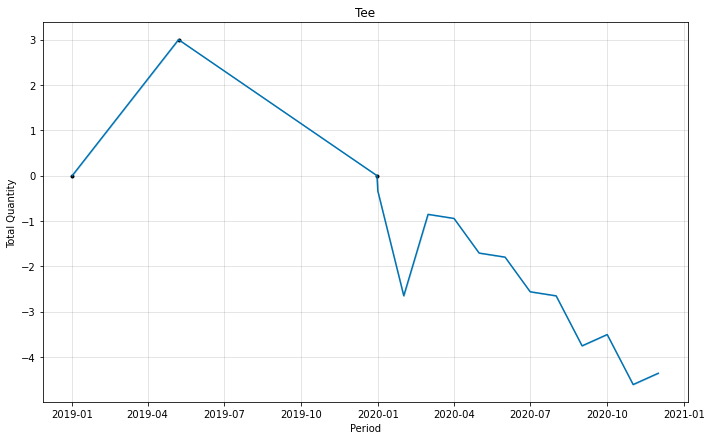

22:57:20 - cmdstanpy - INFO - Chain [1] start processing


BOV


22:57:20 - cmdstanpy - INFO - Chain [1] done processing


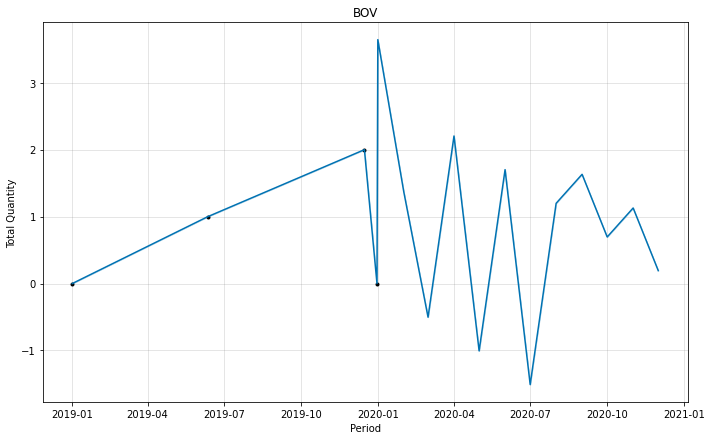

22:57:21 - cmdstanpy - INFO - Chain [1] start processing


Jackets


22:57:23 - cmdstanpy - INFO - Chain [1] done processing


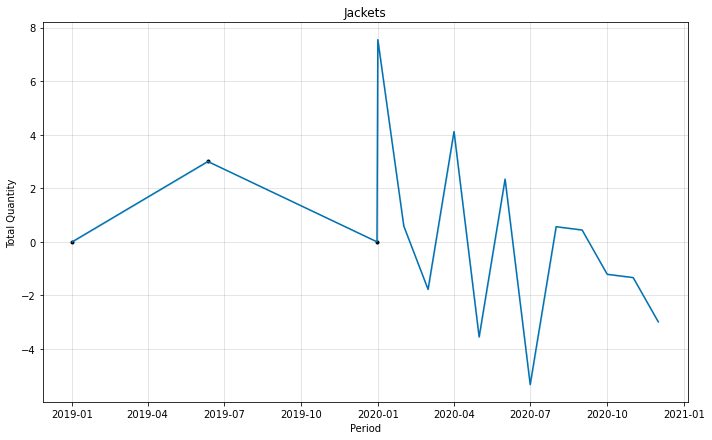

22:57:24 - cmdstanpy - INFO - Chain [1] start processing


Postcards


22:57:24 - cmdstanpy - INFO - Chain [1] done processing


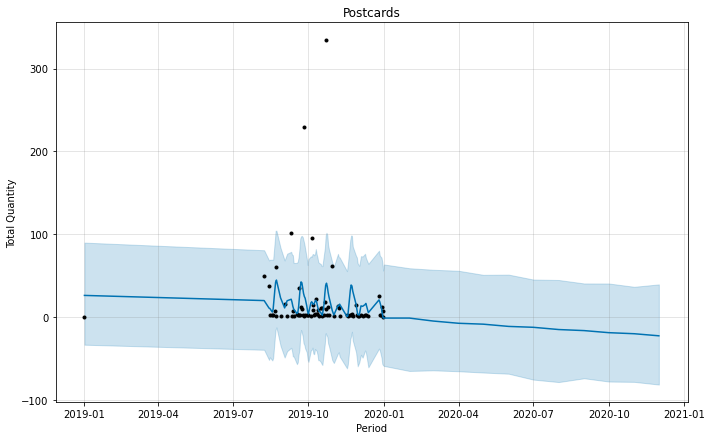

Party


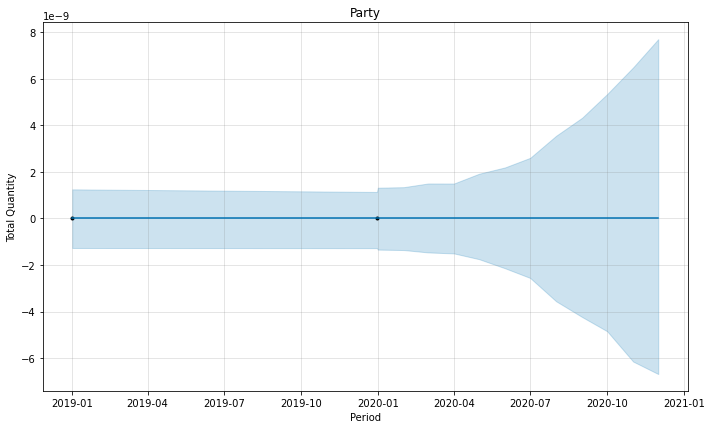

Shoes


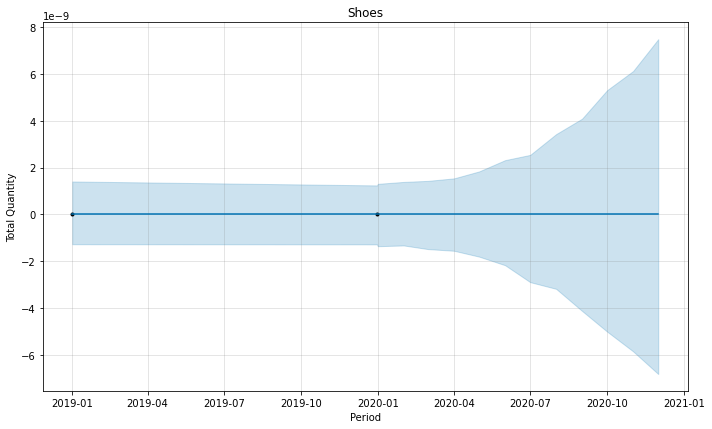

JUMPSUIT WOVEN


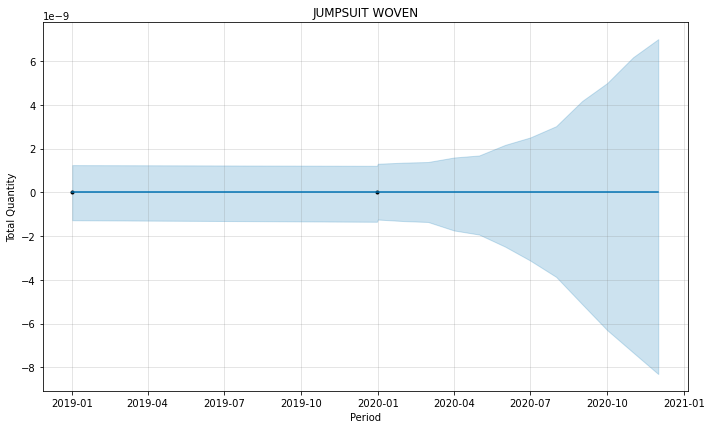

In [312]:
prediction_results_df = pd.DataFrame()

for index, row in article_dimension_df.iterrows():
    print(row[article_dimension])
    
    df_model = factOrder_df[factOrder_df[article_dimension] == row[article_dimension]]
    df_model = df_model.loc[:, ['DateOrderedKey', 'QuantityOrdered']]
    df_model = df_model.reset_index()
    df_model = df_model[['DateOrderedKey', 'QuantityOrdered']]
    df_model.columns = ['ds', 'y']
    #if df_model.shape[0] < 2:
    #    continue
    
    #df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(str(int(train_end_year) - 1) + '-01-01'), 'y' : 0}])])
    df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(train_end_year + '-01-01'), 'y' : 0}])])
    df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(train_end_year + '-12-31'), 'y' : 0}])])
        
    train, test = CreateSplitTestAndTrainData(df_model)
           
    model = CreateModel(train)
    predictions = ModelPrediction(model, row[article_dimension])
    
    
    df_model_performance = pd.merge(test, predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-365:], on='ds')
    
    df_model_performance[article_dimension] = row[article_dimension]    
    prediction_results_df = pd.concat([prediction_results_df, df_model_performance]) 
    
    
    #df_model_cv = cross_validation(model, initial='365.25 days', period='180 days', horizon = '365.25 days')        
    #df_model_performance = performance_metrics(df_model_cv)
    
    #df_model_performance[article_dimension] = row[article_dimension]
    #prediction_results_df = pd.concat([prediction_results_df, df_model_performance])  
    

In [313]:
model.component_modes

{'additive': ['monthly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [314]:
prediction_results_df

ds     y       yhat    yhat_lower    yhat_upper    ArticleGenre
0  2020-04-01   1.0   2.209827 -6.665495e+01  7.791660e+01          Övrigt
1  2020-06-01  -1.0   1.565671 -7.505859e+01  8.231311e+01          Övrigt
2  2020-07-01   6.0  -1.331713 -7.963138e+01  6.885137e+01          Övrigt
3  2020-09-01 -24.0   2.989126 -7.180897e+01  7.618488e+01          Övrigt
4  2020-10-01 -28.0   0.277359 -7.426563e+01  7.060202e+01          Övrigt
..        ...   ...        ...           ...           ...             ...
4  2020-09-01   3.0 -16.352795 -7.392394e+01  4.057013e+01       Postcards
5  2020-10-01   7.0 -18.855951 -7.786391e+01  4.053625e+01       Postcards
6  2020-12-01   5.0 -22.635741 -8.150902e+01  3.944244e+01       Postcards
0  2020-09-01   2.0   0.000000 -4.233654e-09  4.327791e-09           Party
0  2020-08-01  10.0   0.000000 -3.865615e-09  3.023455e-09  JUMPSUIT WOVEN

[529 rows x 6 columns]

In [315]:
prediction_results_df[prediction_results_df[article_dimension] == 'BABY KIT']
#prediction_results_df[12:36]

Empty DataFrame
Columns: [ds, y, yhat, yhat_lower, yhat_upper, ArticleGenre]
Index: []

In [316]:
# Calculate MSE value
model_performance_MSE = mean_squared_error(prediction_results_df['y'], prediction_results_df['yhat'])
print('The MSE for the Prophet model is', model_performance_MSE)

# Calculate RMSE value
model_performance_RMSE = np.sqrt(model_performance_MSE)
print('The RMSE for the Prophet model is', model_performance_RMSE)

# Calculate MAE value
model_performance_MAE = mean_absolute_error(prediction_results_df['y'], prediction_results_df['yhat'])
print(f'The MAE for the Prophet model is', model_performance_MAE)

# Calculate MAPE value
model_performance_APE = np.abs((prediction_results_df['y'] - prediction_results_df['yhat']) / prediction_results_df['y'])
model_performance_MAPE = np.mean(model_performance_APE)
print(f'The MAPE for the Prophet model is', model_performance_MAPE)

#model_performance_MAPE = mean_absolute_percentage_error(prediction_results_df['y'], prediction_results_df['yhat'])
#print(f'The MAPE for the Prophet model is', model_performance_MAPE)

# Calculate MAPE value
model_performance_MDAPE = np.median(model_performance_APE)
print(f'The MAPE for the Prophet model is', model_performance_MDAPE)

The MSE for the Prophet model is 16083.94387535078
The RMSE for the Prophet model is 126.82248962763182
The MAE for the Prophet model is 58.60822935461366
The MAPE for the Prophet model is 9.113855659078911
The MAPE for the Prophet model is 2.911768990365378


In [317]:
# Model performance by Dimension
model_performance_df = pd.DataFrame(pd.np.empty((0, 6)))
model_performance_df.columns = [article_dimension, 'MSE', 'RMSE', 'MAE', 'MAPE', 'MDAPE']

for index, row in article_dimension_df.iterrows():
    print(row[article_dimension])
    prediction_results_temp_df = prediction_results_df[prediction_results_df[article_dimension] == row[article_dimension]]    
    
    if not prediction_results_temp_df.empty:
               
        # Calculate MSE value
        model_performance_MSE = mean_squared_error(prediction_results_temp_df['y'], prediction_results_temp_df['yhat'])

        # Calculate RMSE value
        model_performance_RMSE = np.sqrt(model_performance_MSE)

        # Calculate MAE value
        model_performance_MAE = mean_absolute_error(prediction_results_temp_df['y'], prediction_results_temp_df['yhat'])

        # Calculate MAPE value
        model_performance_APE = np.abs((prediction_results_temp_df['y'] - prediction_results_temp_df['yhat']) / prediction_results_temp_df['y'])
        model_performance_MAPE = np.mean(model_performance_APE)

        # Calculate MDAPE value
        model_performance_MDAPE = np.median(model_performance_APE)

        new_record = {article_dimension : row[article_dimension], 'MSE' : model_performance_MSE, 'RMSE' : model_performance_RMSE,
                      'MAE' : model_performance_MAE, 'MAPE' : model_performance_MAPE, 'MDAPE' : model_performance_MDAPE}

        #new_records.append(new_record)


        model_performance_df = model_performance_df.append(new_record, ignore_index = True)

Övrigt
DRESSES LS WOVEN
SWEATSHIRTS
TEES LS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  model_performance_df = pd.DataFrame(pd.np.empty((0, 6)))
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

TEES SS
DRESSES LS
LEGGINGS
DRESSES SS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

BEANIES
JACKETS UNPADDED
LEGGINGS NB
SKIRTS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

Dungaree
ONESIES
CAPS
BODY LS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

SHIRT/BLOUSE
TROUSERS JERSEY
SWEATPANTS
Jumpsuits Baby


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

SWEATDRESSES
BODY WRAP
SWEATERS
OVERALLS UNPADDED
TIGHTS

C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re


BODY SS
JACKETS PADDED
SKIRTS WOVEN
BAGS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

SOCKS
FLEECE
OTHER HOME
SWIMSUITS
GLOVES
TROUSERS WOVEN


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

BEDDINGS
Giftbox
CARDIGANS
SUNGLASSES
DRESSES STRAP
UV TOPS

C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re


JUMPSUITS
SHORTS
TANKS
SWIMSHORTS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

RAIN & SUN HATS
SWIMPANTS
OVERALLS PADDED
OTHER ACCESSORIES
SHOES
TROUSERS PADDED
DRESSES SS WOVEN


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

SCARVES/BIBS
BABY BOOTS
TROUSERS UNPADDED
DENIM
Summersuit
UV SUITS
BABY KIT

C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re


BATH
Jacket
BODY WOVEN
SHORTS WOVEN
PLAYSUIT
OUTERWEAR
INTERIOR
ROBES
UNDERWEAR
TOP WCT
TROUSERS WCT
TOP
OTH
Caps
KNITTED HATS
BEANIE BABY
HOME
Paperbags store material
Tee
BOV
Jackets
Postcards
Party
Shoes
JUMPSUIT WOVEN


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

In [318]:
model_performance_df

ArticleGenre            MSE        RMSE         MAE       MAPE  \
0             Övrigt     322.836432   17.967650   14.167817   1.352100   
1   DRESSES LS WOVEN    5786.486622   76.068960   56.702913  20.362592   
2        SWEATSHIRTS  104193.831330  322.790693  246.805911   4.327595   
3            TEES LS   26638.831991  163.214068  139.329288   6.281167   
4            TEES SS  260780.689047  510.666906  254.113936   5.666438   
..               ...            ...         ...         ...        ...   
60      KNITTED HATS   86905.088209  294.796690  246.557285  67.998629   
61       BEANIE BABY     587.059887   24.229319   22.000881  13.647061   
62         Postcards     507.414192   22.525856   19.864978   4.438918   
63             Party       4.000000    2.000000    2.000000   1.000000   
64    JUMPSUIT WOVEN     100.000000   10.000000   10.000000   1.000000   

        MDAPE  
0    1.167187  
1   11.526415  
2    2.754767  
3    1.614077  
4    2.287210  
..        ...  
60  59.023752  
61  10.071468  
62   5.294300  
63   1.000000  
64   1.000000  

[65 rows x 6 columns]

In [321]:
#model_performance_df.to_csv('model_performance_df.csv', index=False)
#prediction_results_df.to_csv('prediction_results_df.csv', index=False)

In [320]:
#model_performance_df[model_performance_df[article_dimension] == 'BABY BOOTS']

Empty DataFrame
Columns: [ArticleGenre, MSE, RMSE, MAE, MAPE, MDAPE]
Index: []